<p style="font-size:14pt;text-align:center;">
Training Fast R-CNN network on PascalVOC 2005.
</p>

In [306]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import numpy.random as npr
import theano
from theano import tensor as T
import pickle as pk
import re
from copy import deepcopy
import sys
from tqdm import tqdm
from itertools import tee

# image processing
from skimage.io import imread
from skimage.transform import resize
from skimage.color import rgb2hsv, hsv2rgb

import lasagne
from lasagne.layers import Pool2DLayer, Conv2DLayer, dropout, \
    DenseLayer, InputLayer, get_output, get_all_params, set_all_param_values
import lasagne.layers as layers
import lasagne.objectives as objectives
import lasagne.nonlinearities as nonlinearities
    
import bnr_ml.objectdetect.fastrcnn as fastrcnn
import bnr_ml.utils.helpers as helpers
from bnr_ml.objectdetect.utils import BoundingBox, draw_coord
import bnr_ml.objectdetect.utils as utils

from selectivesearch import selective_search

import simplejson

import pdb

In [489]:
with open('/usr/local/python/bnr_ml/data/PascalVOC/annotations.json', 'r') as f:
    annotations = simplejson.load(f)

In [490]:
# def add_proper_labels(annotations):
#     for im in annotations:
#         for obj in im:
#             if 'car' in obj['label'].lower():
#                 obj['label'] = 'car'
#             elif 'bicycle' in obj['label'].lower():
#                 obj['label'] = 'bicycle'
#             elif 'person' in obj['label'].lower():
#                 obj['label'] = 'person'
#             elif 'motorbike' in obj['label'].lower():
#                 obj['label'] = 'bike'
#             elif 'bike' in obj['label'].lower():
#                 obj['label'] = 'bicycle'
#             else:
#                 print obj

In [492]:
def get_label_counts(annotations):
    counts = np.zeros((4,))
    for a in annotations:
        for obj in a['annotations']:
            if obj['label'] == 'car':
                counts[0] += 1
            elif obj['label'] == 'bicycle':
                counts[1] += 1
            elif obj['label'] == 'bike':
                counts[2] += 1
            else:
                counts[3] += 1
    return counts

In [493]:
def fix_labels(annotations):
    for a in annotations:
        a['image'] = '/usr/local/python/bnr_ml/data/PascalVOC/' + a['image']
        new_objs = []
        for obj in a['annotations']:
            lab = obj['label'].lower()
            if 'car' in lab:
                lab = 'car'
            elif 'person' in lab:
                lab = 'person'
            elif 'bike' in lab:
                lab = 'bike'
            elif 'bicycle' in lab:
                lab = 'bicycle'
            else:
                lab = None
                
            if lab != None:
                obj['label'] = lab
                new_objs.append(obj)
        a['annotations'] = new_objs
    return annotations

In [494]:
# def fix_obj(obj):
#     x, y = obj['p1'][0], obj['p1'][1]
#     w, h = obj['p2'][0] - x, obj['p2'][1] - y
#     obj['x'], obj['y'], obj['w'], obj['h'] = x, y, w, h
#     del obj['p1'], obj['p2']
#     return get_num_from_label(obj)

In [495]:
# add_proper_dlabels(annotations)

In [496]:
annotations = fix_labels(annotations)

In [497]:
annotations = np.asarray(annotations)

In [498]:
counts = get_label_counts(annotations)

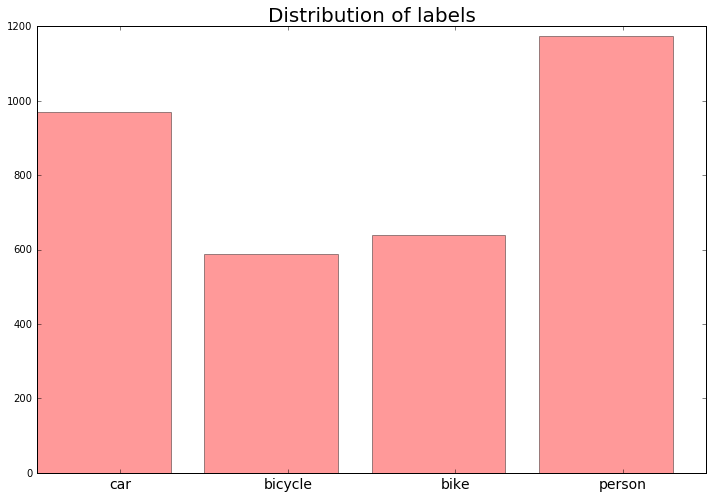

In [499]:
plt.figure(figsize=(12,8))
plt.title('Distribution of labels', fontsize=20)
plt.bar(np.arange(counts.size), counts, color='red', alpha=.4)
plt.xticks(np.arange(counts.size) + .5, ['car', 'bicycle', 'bike', 'person'], fontsize=14)
plt.show()

In [500]:
np.random.seed(1991)

<b>Split the annotations for training and testing, the reason I split by image and not individual object is so that when testing the performance, the network will never have seen any part of the test image.

In [501]:
with open('indices.pkl', 'rb') as f:
    indices = pk.load(f)
    train_idx = indices['train_index']
    test_idx = indices['test_index']

In [502]:
train_annotations = annotations[train_idx]
test_annotations = annotations[test_idx]

<b>Fix annotations so that you can use the static method for generating data for fast r-cnn.</b>

<b>Now we define the net for recognition.</b>

In [503]:
num_epochs = 1000
batch_size = 50

In [504]:
num_classes = 4

In [505]:
lab2num = {
    'car': 0,
    'bicycle': 1,
    'bike': 2,
    'person': 3,
    'nothing': 4
}

In [506]:
reload(fastrcnn)

<module 'bnr_ml.objectdetect.fastrcnn' from '/usr/local/python/bnr_ml/objectdetect/fastrcnn.pyc'>

In [507]:
input_shape = (224,224)

In [508]:
test_net = False
if test_net:
    gen = test_gen = fastrcnn.generate_rois(
        test_annotations[10:12],
        input_shape,
        num_classes,
        lab2num,
        N=20,
        neg=.5
    )
    X,y = [g for g in gen][0]
    X,y = theano.shared(X), theano.shared(y)
    input_var = X
else:
    input_var = None

In [510]:
net = {}
net['input'] = InputLayer((None,3) + input_shape, input_var=input_var)
net['conv1'] = Conv2DLayer(net['input'], 16, (3,3), nonlinearity=nonlinearities.leaky_rectify)
net['conv2'] = Conv2DLayer(net['conv1'], 16, (3,3), nonlinearity=nonlinearities.leaky_rectify)
net['pool1'] = Pool2DLayer(net['conv2'], (2,2))
net['conv3'] = Conv2DLayer(net['pool1'], 32, (3,3), nonlinearity=nonlinearities.leaky_rectify)
net['conv4'] = Conv2DLayer(net['conv3'], 32, (3,3), nonlinearity=nonlinearities.leaky_rectify)
net['pool2'] = Pool2DLayer(net['conv4'], (2,2))
net['conv5'] = Conv2DLayer(net['pool2'], 64, (3,3), nonlinearity=nonlinearities.leaky_rectify)
net['conv6'] = Conv2DLayer(net['conv5'], 64, (3,3), nonlinearity=nonlinearities.leaky_rectify)
net['conv7'] = Conv2DLayer(net['conv6'], 64, (1,1), nonlinearity=nonlinearities.leaky_rectify)
net['pool3'] = Pool2DLayer(net['conv7'], (2,2))
net['conv8'] = Conv2DLayer(net['pool3'], 128, (3,3), nonlinearity=nonlinearities.leaky_rectify)
net['conv9'] = Conv2DLayer(net['conv8'], 128, (3,3), nonlinearity=nonlinearities.leaky_rectify)
net['conv10'] = Conv2DLayer(net['conv9'], 128, (1,1), nonlinearity=nonlinearities.leaky_rectify)
net['pool4'] = Pool2DLayer(net['conv10'], (2,2))
net['conv11'] = Conv2DLayer(net['pool4'], 128, (3,3), nonlinearity=nonlinearities.leaky_rectify)
net['conv12'] = Conv2DLayer(net['conv11'], 128, (3,3), nonlinearity=nonlinearities.leaky_rectify)
net['conv13'] = Conv2DLayer(net['conv12'], 128, (1,1), nonlinearity=nonlinearities.leaky_rectify)


net['dense1'] = DenseLayer(dropout(net['conv13'], p=.75), 2048, nonlinearity=None)
# net['dense2'] = DenseLayer(dropout(net['dense1'], p=.5), 2048)
net['dense2'] = DenseLayer(dropout(net['dense1'], p=.75), (2 * 5 + 4) * (6*6))
net['output'] = DenseLayer(dropout(net['dense2'], p=.75), 5, nonlinearity=lasagne.nonlinearities.softmax)

<b>Load pre-trained weights</b>

In [511]:
load_pretrained = True
if load_pretrained:
    with open('pretrained_weights_2.pkl', 'rb') as f:
        weights = pk.load(f)
        lasagne.layers.set_all_param_values(net['output'], weights)

<b>Add extra layers to network for detection</b>

In [512]:
net['dense2'] = DenseLayer(dropout(net['dense1'], p=.75), 2048, nonlinearity=None)
net['detect'] = DenseLayer(dropout(net['dense2'], p=.75), 5, nonlinearity=lasagne.nonlinearities.softmax)
net['localize'] = DenseLayer(dropout(net['dense2'], p=.75), (num_classes + 1) * 4)

In [513]:
load_weights = False
if load_weights:
    with open('fastrcnn_weights.pkl', 'rb') as f:
        params = pk.load(f)
        tmp = params[:-4]
        tmp.extend(params[-2:])
        set_all_param_values(net['detect'], params[:-2])
        set_all_param_values(net['localize'], tmp)

<b>Train the network

In [514]:
reload(fastrcnn)
reload(utils)

<module 'bnr_ml.objectdetect.utils' from '/usr/local/python/bnr_ml/objectdetect/utils.pyc'>

In [515]:
detector = fastrcnn.FastRCNNDetector(net, num_classes)

cost = detector._get_cost(detector._detect_test, detector._localize_test, y)

In [516]:
print_obj = helpers.NotebookPrinter(open('/dev/stdout', 'w'), sys.stdout)

In [517]:
train_loss, test_loss = detector.train(
    train_annotations[:],
    test_annotations[:],
    lab2num,
    print_obj,
#     num_batch_test=2,
#     N_test=20,
#     neg_test=.5,
    lr=1e-5,
    lmbda=1.,
    epochs=num_epochs
)

Getting cost...
Compiling...


  0%|          | 0/893 [00:00<?, ?it/s]

Compiling took 24.449 seconds
Beginning training


  0%|          | 1/893 [00:01<26:32,  1.78s/it]

Batch error: 2.3088


  0%|          | 2/893 [00:03<26:36,  1.79s/it]

Batch error: 2.7416


  0%|          | 3/893 [00:05<26:29,  1.79s/it]

Batch error: 2.1317


  0%|          | 4/893 [00:07<26:51,  1.81s/it]

Batch error: 2.3664


  1%|          | 5/893 [00:09<26:53,  1.82s/it]

Batch error: 2.0775


  1%|          | 6/893 [00:10<26:54,  1.82s/it]

Batch error: 2.1870


  1%|          | 7/893 [00:12<27:15,  1.85s/it]

Batch error: 1.8651


  1%|          | 8/893 [00:14<27:08,  1.84s/it]

Batch error: 2.0234


  1%|          | 9/893 [00:16<27:13,  1.85s/it]

Batch error: 2.1345


  1%|          | 10/893 [00:18<27:07,  1.84s/it]

Batch error: 2.1601


  1%|          | 11/893 [00:20<27:44,  1.89s/it]

Batch error: 2.3485


  1%|▏         | 12/893 [00:22<27:41,  1.89s/it]

Batch error: 2.1301


  1%|▏         | 13/893 [00:24<27:41,  1.89s/it]

Batch error: 2.0672


  2%|▏         | 14/893 [00:25<27:17,  1.86s/it]

Batch error: 1.9250


  2%|▏         | 15/893 [00:27<27:04,  1.85s/it]

Batch error: 2.2324


  2%|▏         | 16/893 [00:29<26:43,  1.83s/it]

Batch error: 1.9372


  2%|▏         | 17/893 [00:31<26:29,  1.81s/it]

Batch error: 1.7694


  2%|▏         | 18/893 [00:33<26:25,  1.81s/it]

Batch error: 1.6013


  2%|▏         | 19/893 [00:35<27:09,  1.86s/it]

Batch error: 2.0877


  2%|▏         | 20/893 [00:36<26:50,  1.84s/it]

Batch error: 1.7612


  2%|▏         | 21/893 [00:38<26:56,  1.85s/it]

Batch error: 2.0267


  2%|▏         | 22/893 [00:41<30:14,  2.08s/it]

Batch error: 2.0362


  3%|▎         | 23/893 [00:43<29:06,  2.01s/it]

Batch error: 1.9658


  3%|▎         | 24/893 [00:45<28:24,  1.96s/it]

Batch error: 1.5849


  3%|▎         | 25/893 [00:46<27:35,  1.91s/it]

Batch error: 1.8350


  3%|▎         | 26/893 [00:48<28:02,  1.94s/it]

Batch error: 1.9287


  3%|▎         | 27/893 [00:50<27:25,  1.90s/it]

Batch error: 1.7168


  3%|▎         | 28/893 [00:52<28:03,  1.95s/it]

Batch error: 2.0142


  3%|▎         | 29/893 [00:54<27:43,  1.92s/it]

Batch error: 1.8410


  3%|▎         | 30/893 [00:56<28:02,  1.95s/it]

Batch error: 1.9325


  3%|▎         | 31/893 [00:58<28:20,  1.97s/it]

Batch error: 2.3706


  4%|▎         | 32/893 [01:00<27:37,  1.93s/it]

Batch error: 1.9009


  4%|▎         | 33/893 [01:02<26:57,  1.88s/it]

Batch error: 1.7454


  4%|▍         | 34/893 [01:04<26:50,  1.87s/it]

Batch error: 1.8362


  4%|▍         | 35/893 [01:05<26:42,  1.87s/it]

Batch error: 1.6994


  4%|▍         | 36/893 [01:07<26:25,  1.85s/it]

Batch error: 1.4643


  4%|▍         | 37/893 [01:10<29:47,  2.09s/it]

Batch error: 1.8783


  4%|▍         | 38/893 [01:12<28:36,  2.01s/it]

Batch error: 1.7799


  4%|▍         | 39/893 [01:13<27:30,  1.93s/it]

Batch error: 1.6350


  4%|▍         | 40/893 [01:15<26:51,  1.89s/it]

Batch error: 1.6783


  5%|▍         | 41/893 [01:17<26:23,  1.86s/it]

Batch error: 1.7623


  5%|▍         | 42/893 [01:19<26:42,  1.88s/it]

Batch error: 1.6948


  5%|▍         | 43/893 [01:21<26:21,  1.86s/it]

Batch error: 1.5713


  5%|▍         | 44/893 [01:23<26:25,  1.87s/it]

Batch error: 1.7594


  5%|▌         | 45/893 [01:25<27:44,  1.96s/it]

Batch error: 1.8213


  5%|▌         | 46/893 [01:27<26:56,  1.91s/it]

Batch error: 1.4738


  5%|▌         | 47/893 [01:29<26:54,  1.91s/it]

Batch error: 1.6714


  5%|▌         | 48/893 [01:30<26:21,  1.87s/it]

Batch error: 1.4443


  5%|▌         | 49/893 [01:32<26:21,  1.87s/it]

Batch error: 1.7940


  6%|▌         | 50/893 [01:34<25:51,  1.84s/it]

Batch error: 1.6241


  6%|▌         | 51/893 [01:36<25:57,  1.85s/it]

Batch error: 1.6079


  6%|▌         | 52/893 [01:38<25:34,  1.82s/it]

Batch error: 1.4407


  6%|▌         | 53/893 [01:39<25:24,  1.81s/it]

Batch error: 1.6336


  6%|▌         | 54/893 [01:41<25:15,  1.81s/it]

Batch error: 1.4566


  6%|▌         | 55/893 [01:43<25:25,  1.82s/it]

Batch error: 1.5606


  6%|▋         | 56/893 [01:45<25:12,  1.81s/it]

Batch error: 1.4249


  6%|▋         | 57/893 [01:47<25:02,  1.80s/it]

Batch error: 1.5619


  6%|▋         | 58/893 [01:48<24:55,  1.79s/it]

Batch error: 1.2583


  7%|▋         | 59/893 [01:50<25:00,  1.80s/it]

Batch error: 1.5603


  7%|▋         | 60/893 [01:52<25:17,  1.82s/it]

Batch error: 1.5942


  7%|▋         | 61/893 [01:54<25:19,  1.83s/it]

Batch error: 1.6405


  7%|▋         | 62/893 [01:56<25:16,  1.83s/it]

Batch error: 1.2407


  7%|▋         | 63/893 [01:58<25:14,  1.82s/it]

Batch error: 1.6681


  7%|▋         | 64/893 [01:59<25:05,  1.82s/it]

Batch error: 1.2389


  7%|▋         | 65/893 [02:01<24:52,  1.80s/it]

Batch error: 1.1432


  7%|▋         | 66/893 [02:03<24:49,  1.80s/it]

Batch error: 1.5805


  8%|▊         | 67/893 [02:05<24:50,  1.80s/it]

Batch error: 1.6689


  8%|▊         | 68/893 [02:07<24:47,  1.80s/it]

Batch error: 1.2601


  8%|▊         | 69/893 [02:08<24:37,  1.79s/it]

Batch error: 1.2329


  8%|▊         | 70/893 [02:10<24:33,  1.79s/it]

Batch error: 1.6617


  8%|▊         | 71/893 [02:12<25:00,  1.83s/it]

Batch error: 1.6210


  8%|▊         | 72/893 [02:14<24:56,  1.82s/it]

Batch error: 1.5730


  8%|▊         | 73/893 [02:17<29:36,  2.17s/it]

Batch error: 2.1135


  8%|▊         | 74/893 [02:19<28:23,  2.08s/it]

Batch error: 1.5697


  8%|▊         | 75/893 [02:20<27:09,  1.99s/it]

Batch error: 1.6781


  9%|▊         | 76/893 [02:23<27:46,  2.04s/it]

Batch error: 1.2787


  9%|▊         | 77/893 [02:24<26:41,  1.96s/it]

Batch error: 1.1838


  9%|▊         | 78/893 [02:26<26:03,  1.92s/it]

Batch error: 1.6809


  9%|▉         | 79/893 [02:28<25:48,  1.90s/it]

Batch error: 1.6324


  9%|▉         | 80/893 [02:30<26:59,  1.99s/it]

Batch error: 1.5296


  9%|▉         | 81/893 [02:32<26:44,  1.98s/it]

Batch error: 1.5707


  9%|▉         | 82/893 [02:34<26:21,  1.95s/it]

Batch error: 1.5642


  9%|▉         | 83/893 [02:36<25:40,  1.90s/it]

Batch error: 1.1283


  9%|▉         | 84/893 [02:38<26:13,  1.94s/it]

Batch error: 1.3351


 10%|▉         | 85/893 [02:40<26:03,  1.93s/it]

Batch error: 1.2780


 10%|▉         | 86/893 [02:42<25:27,  1.89s/it]

Batch error: 1.5650


 10%|▉         | 87/893 [02:43<25:08,  1.87s/it]

Batch error: 1.4123


 10%|▉         | 88/893 [02:46<26:18,  1.96s/it]

Batch error: 1.7002


 10%|▉         | 89/893 [02:47<25:50,  1.93s/it]

Batch error: 1.0091


 10%|█         | 90/893 [02:49<25:21,  1.89s/it]

Batch error: 1.0480


 10%|█         | 91/893 [02:51<25:15,  1.89s/it]

Batch error: 1.8344


 10%|█         | 92/893 [02:53<24:45,  1.85s/it]

Batch error: 0.9806


 10%|█         | 93/893 [02:55<24:29,  1.84s/it]

Batch error: 1.6019


 11%|█         | 94/893 [02:57<24:26,  1.84s/it]

Batch error: 1.4672


 11%|█         | 95/893 [02:58<24:27,  1.84s/it]

Batch error: 1.5896


 11%|█         | 96/893 [03:00<24:10,  1.82s/it]

Batch error: 1.1378


 11%|█         | 97/893 [03:02<24:13,  1.83s/it]

Batch error: 0.9929


 11%|█         | 98/893 [03:04<24:12,  1.83s/it]

Batch error: 1.4234


 11%|█         | 99/893 [03:06<24:03,  1.82s/it]

Batch error: 1.2374


 11%|█         | 100/893 [03:07<23:58,  1.81s/it]

Batch error: 1.4751


 11%|█▏        | 101/893 [03:09<23:54,  1.81s/it]

Batch error: 0.9791


 11%|█▏        | 102/893 [03:11<24:05,  1.83s/it]

Batch error: 0.9198


 12%|█▏        | 103/893 [03:14<28:29,  2.16s/it]

Batch error: 1.8515


 12%|█▏        | 104/893 [03:16<28:06,  2.14s/it]

Batch error: 1.8781


 12%|█▏        | 105/893 [03:18<28:24,  2.16s/it]

Batch error: 1.4007


 12%|█▏        | 106/893 [03:20<27:26,  2.09s/it]

Batch error: 1.3308


 12%|█▏        | 107/893 [03:22<26:24,  2.02s/it]

Batch error: 1.3043


 12%|█▏        | 108/893 [03:24<25:54,  1.98s/it]

Batch error: 1.5769


 12%|█▏        | 109/893 [03:26<25:30,  1.95s/it]

Batch error: 1.5227


 12%|█▏        | 110/893 [03:28<24:51,  1.90s/it]

Batch error: 1.0785


 12%|█▏        | 111/893 [03:29<24:22,  1.87s/it]

Batch error: 0.8100


 13%|█▎        | 112/893 [03:31<24:06,  1.85s/it]

Batch error: 1.6831


 13%|█▎        | 113/893 [03:33<23:46,  1.83s/it]

Batch error: 0.8336


 13%|█▎        | 114/893 [03:35<25:02,  1.93s/it]

Batch error: 1.6429


 13%|█▎        | 115/893 [03:37<24:39,  1.90s/it]

Batch error: 1.4061


 13%|█▎        | 116/893 [03:39<25:41,  1.98s/it]

Batch error: 1.3262


 13%|█▎        | 117/893 [03:41<25:04,  1.94s/it]

Batch error: 1.2129


 13%|█▎        | 118/893 [03:43<24:22,  1.89s/it]

Batch error: 0.9848


 13%|█▎        | 119/893 [03:45<24:00,  1.86s/it]

Batch error: 1.3621


 13%|█▎        | 120/893 [03:46<23:39,  1.84s/it]

Batch error: 0.9955


 14%|█▎        | 121/893 [03:48<23:30,  1.83s/it]

Batch error: 0.6804


 14%|█▎        | 122/893 [03:50<24:57,  1.94s/it]

Batch error: 1.3622


 14%|█▍        | 123/893 [03:52<24:37,  1.92s/it]

Batch error: 1.2135


 14%|█▍        | 124/893 [03:54<24:19,  1.90s/it]

Batch error: 0.8809


 14%|█▍        | 125/893 [03:56<24:33,  1.92s/it]

Batch error: 1.2692


 14%|█▍        | 126/893 [03:58<24:12,  1.89s/it]

Batch error: 1.3195


 14%|█▍        | 127/893 [04:00<23:51,  1.87s/it]

Batch error: 0.8296


 14%|█▍        | 128/893 [04:02<23:47,  1.87s/it]

Batch error: 1.2894


 14%|█▍        | 129/893 [04:03<23:30,  1.85s/it]

Batch error: 1.2748


 15%|█▍        | 130/893 [04:05<23:23,  1.84s/it]

Batch error: 1.5541


 15%|█▍        | 131/893 [04:07<23:14,  1.83s/it]

Batch error: 1.0597


 15%|█▍        | 132/893 [04:09<23:28,  1.85s/it]

Batch error: 1.2925


 15%|█▍        | 133/893 [04:11<23:34,  1.86s/it]

Batch error: 1.3795


 15%|█▌        | 134/893 [04:13<23:26,  1.85s/it]

Batch error: 1.2027


 15%|█▌        | 135/893 [04:14<23:11,  1.84s/it]

Batch error: 0.8316


 15%|█▌        | 136/893 [04:16<22:57,  1.82s/it]

Batch error: 1.3836


 15%|█▌        | 137/893 [04:18<23:02,  1.83s/it]

Batch error: 1.4918


 15%|█▌        | 138/893 [04:20<23:02,  1.83s/it]

Batch error: 0.9979


 16%|█▌        | 139/893 [04:22<23:19,  1.86s/it]

Batch error: 1.2647


 16%|█▌        | 140/893 [04:24<23:17,  1.86s/it]

Batch error: 1.0740


 16%|█▌        | 141/893 [04:26<23:10,  1.85s/it]

Batch error: 1.4010


 16%|█▌        | 142/893 [04:27<22:55,  1.83s/it]

Batch error: 1.1449


 16%|█▌        | 143/893 [04:29<22:50,  1.83s/it]

Batch error: 1.3853


 16%|█▌        | 144/893 [04:31<22:46,  1.82s/it]

Batch error: 1.3655


 16%|█▌        | 145/893 [04:33<22:49,  1.83s/it]

Batch error: 1.1102


 16%|█▋        | 146/893 [04:35<22:46,  1.83s/it]

Batch error: 0.9845


 16%|█▋        | 147/893 [04:37<22:55,  1.84s/it]

Batch error: 1.4052


 17%|█▋        | 148/893 [04:38<22:59,  1.85s/it]

Batch error: 1.3150


 17%|█▋        | 149/893 [04:42<30:40,  2.47s/it]

Batch error: 1.6560


 17%|█▋        | 150/893 [04:44<28:09,  2.27s/it]

Batch error: 1.0661


 17%|█▋        | 151/893 [04:46<26:35,  2.15s/it]

Batch error: 1.3764


 17%|█▋        | 152/893 [04:48<25:31,  2.07s/it]

Batch error: 1.2661


 17%|█▋        | 153/893 [04:50<25:00,  2.03s/it]

Batch error: 1.5218


 17%|█▋        | 154/893 [04:52<24:11,  1.96s/it]

Batch error: 0.8382


 17%|█▋        | 155/893 [04:53<23:49,  1.94s/it]

Batch error: 1.2569


 17%|█▋        | 156/893 [04:55<23:21,  1.90s/it]

Batch error: 0.7825


 18%|█▊        | 157/893 [04:57<23:11,  1.89s/it]

Batch error: 1.2437


 18%|█▊        | 158/893 [04:59<22:57,  1.87s/it]

Batch error: 1.0171


 18%|█▊        | 159/893 [05:01<23:34,  1.93s/it]

Batch error: 1.3999


 18%|█▊        | 160/893 [05:03<23:22,  1.91s/it]

Batch error: 1.3582


 18%|█▊        | 161/893 [05:05<24:02,  1.97s/it]

Batch error: 1.8382


 18%|█▊        | 162/893 [05:07<23:37,  1.94s/it]

Batch error: 0.9171


 18%|█▊        | 163/893 [05:09<23:20,  1.92s/it]

Batch error: 0.7684


 18%|█▊        | 164/893 [05:11<23:24,  1.93s/it]

Batch error: 1.2620


 18%|█▊        | 165/893 [05:13<23:07,  1.91s/it]

Batch error: 1.1165


 19%|█▊        | 166/893 [05:15<23:09,  1.91s/it]

Batch error: 1.0204


 19%|█▊        | 167/893 [05:16<23:09,  1.91s/it]

Batch error: 1.1749


 19%|█▉        | 168/893 [05:18<23:43,  1.96s/it]

Batch error: 1.3740


 19%|█▉        | 169/893 [05:20<23:32,  1.95s/it]

Batch error: 1.1738


 19%|█▉        | 170/893 [05:22<23:14,  1.93s/it]

Batch error: 1.2291


 19%|█▉        | 171/893 [05:24<23:00,  1.91s/it]

Batch error: 1.1958


 19%|█▉        | 172/893 [05:26<23:07,  1.92s/it]

Batch error: 1.3852


 19%|█▉        | 173/893 [05:29<27:16,  2.27s/it]

Batch error: 1.7348


 19%|█▉        | 174/893 [05:32<29:56,  2.50s/it]

Batch error: 1.6352


 20%|█▉        | 175/893 [05:34<27:49,  2.32s/it]

Batch error: 0.8930


 20%|█▉        | 176/893 [05:36<26:23,  2.21s/it]

Batch error: 1.2426


 20%|█▉        | 177/893 [05:38<25:26,  2.13s/it]

Batch error: 1.1252


 20%|█▉        | 178/893 [05:40<24:30,  2.06s/it]

Batch error: 0.7498


 20%|██        | 179/893 [05:42<23:48,  2.00s/it]

Batch error: 0.6529


 20%|██        | 180/893 [05:44<23:50,  2.01s/it]

Batch error: 1.7811


 20%|██        | 181/893 [05:46<23:55,  2.02s/it]

Batch error: 1.6239


 20%|██        | 182/893 [05:48<23:24,  1.98s/it]

Batch error: 1.1695


 20%|██        | 183/893 [05:50<22:51,  1.93s/it]

Batch error: 0.8497


 21%|██        | 184/893 [05:51<22:30,  1.90s/it]

Batch error: 1.0911


 21%|██        | 185/893 [05:53<22:10,  1.88s/it]

Batch error: 0.8958


 21%|██        | 186/893 [05:55<21:45,  1.85s/it]

Batch error: 0.7803


 21%|██        | 187/893 [05:57<22:18,  1.90s/it]

Batch error: 1.7584


 21%|██        | 188/893 [05:59<22:05,  1.88s/it]

Batch error: 0.7895


 21%|██        | 189/893 [06:01<22:08,  1.89s/it]

Batch error: 0.8240


 21%|██▏       | 190/893 [06:06<32:34,  2.78s/it]

Batch error: 1.4587


 21%|██▏       | 191/893 [06:07<29:02,  2.48s/it]

Batch error: 1.1747


 22%|██▏       | 192/893 [06:10<30:32,  2.61s/it]

Batch error: 1.5952


 22%|██▏       | 193/893 [06:12<27:46,  2.38s/it]

Batch error: 1.1381


 22%|██▏       | 194/893 [06:14<25:53,  2.22s/it]

Batch error: 1.2171


 22%|██▏       | 195/893 [06:16<24:27,  2.10s/it]

Batch error: 1.0099


 22%|██▏       | 196/893 [06:18<23:28,  2.02s/it]

Batch error: 1.5287


 22%|██▏       | 197/893 [06:19<22:40,  1.95s/it]

Batch error: 0.5046


 22%|██▏       | 198/893 [06:21<22:02,  1.90s/it]

Batch error: 1.2918


 22%|██▏       | 199/893 [06:23<21:47,  1.88s/it]

Batch error: 0.8337


 22%|██▏       | 200/893 [06:25<21:59,  1.90s/it]

Batch error: 0.9340


 23%|██▎       | 201/893 [06:27<21:56,  1.90s/it]

Batch error: 1.1947


 23%|██▎       | 202/893 [06:29<21:32,  1.87s/it]

Batch error: 0.7011


 23%|██▎       | 203/893 [06:31<21:19,  1.85s/it]

Batch error: 0.6275


 23%|██▎       | 204/893 [06:32<20:58,  1.83s/it]

Batch error: 0.7357


 23%|██▎       | 205/893 [06:34<21:06,  1.84s/it]

Batch error: 0.8301


 23%|██▎       | 206/893 [06:36<21:03,  1.84s/it]

Batch error: 1.5550


 23%|██▎       | 207/893 [06:38<20:52,  1.83s/it]

Batch error: 0.9323


 23%|██▎       | 208/893 [06:40<20:50,  1.83s/it]

Batch error: 0.7031


 23%|██▎       | 209/893 [06:41<20:41,  1.81s/it]

Batch error: 1.2254


 24%|██▎       | 210/893 [06:43<20:38,  1.81s/it]

Batch error: 0.9278


 24%|██▎       | 211/893 [06:45<20:39,  1.82s/it]

Batch error: 1.1120


 24%|██▎       | 212/893 [06:47<21:11,  1.87s/it]

Batch error: 1.2096


 24%|██▍       | 213/893 [06:49<21:01,  1.86s/it]

Batch error: 1.0431


 24%|██▍       | 214/893 [06:51<20:53,  1.85s/it]

Batch error: 0.6659


 24%|██▍       | 215/893 [06:53<20:54,  1.85s/it]

Batch error: 1.2746


 24%|██▍       | 216/893 [06:54<20:35,  1.82s/it]

Batch error: 0.7261


 24%|██▍       | 217/893 [06:56<20:41,  1.84s/it]

Batch error: 1.0408


 24%|██▍       | 218/893 [06:58<20:28,  1.82s/it]

Batch error: 0.7070


 25%|██▍       | 219/893 [07:00<20:17,  1.81s/it]

Batch error: 1.1550


 25%|██▍       | 220/893 [07:02<20:23,  1.82s/it]

Batch error: 1.2368


 25%|██▍       | 221/893 [07:03<20:31,  1.83s/it]

Batch error: 0.8879


 25%|██▍       | 222/893 [07:05<20:37,  1.84s/it]

Batch error: 1.2740


 25%|██▍       | 223/893 [07:07<20:26,  1.83s/it]

Batch error: 0.7721


 25%|██▌       | 224/893 [07:09<20:25,  1.83s/it]

Batch error: 0.8037


 25%|██▌       | 225/893 [07:11<20:23,  1.83s/it]

Batch error: 0.8506


 25%|██▌       | 226/893 [07:13<20:18,  1.83s/it]

Batch error: 0.8999


 25%|██▌       | 227/893 [07:14<20:11,  1.82s/it]

Batch error: 1.1305


 26%|██▌       | 228/893 [07:16<20:07,  1.82s/it]

Batch error: 1.1814


 26%|██▌       | 229/893 [07:18<20:14,  1.83s/it]

Batch error: 1.0515


 26%|██▌       | 230/893 [07:21<22:54,  2.07s/it]

Batch error: 1.5549


 26%|██▌       | 231/893 [07:23<22:05,  2.00s/it]

Batch error: 0.9993


 26%|██▌       | 232/893 [07:24<21:20,  1.94s/it]

Batch error: 1.2249


 26%|██▌       | 233/893 [07:26<21:00,  1.91s/it]

Batch error: 1.0261


 26%|██▌       | 234/893 [07:28<20:52,  1.90s/it]

Batch error: 0.9774


 26%|██▋       | 235/893 [07:30<20:40,  1.88s/it]

Batch error: 1.0552


 26%|██▋       | 236/893 [07:32<20:37,  1.88s/it]

Batch error: 1.3152


 27%|██▋       | 237/893 [07:34<20:23,  1.87s/it]

Batch error: 1.0418


 27%|██▋       | 238/893 [07:35<20:17,  1.86s/it]

Batch error: 1.1559


 27%|██▋       | 239/893 [07:37<20:03,  1.84s/it]

Batch error: 0.6491


 27%|██▋       | 240/893 [07:39<19:50,  1.82s/it]

Batch error: 0.7764


 27%|██▋       | 241/893 [07:41<19:47,  1.82s/it]

Batch error: 1.0718


 27%|██▋       | 242/893 [07:43<19:53,  1.83s/it]

Batch error: 0.9529


 27%|██▋       | 243/893 [07:45<19:48,  1.83s/it]

Batch error: 1.1307


 27%|██▋       | 244/893 [07:46<19:42,  1.82s/it]

Batch error: 1.3412


 27%|██▋       | 245/893 [07:48<19:30,  1.81s/it]

Batch error: 0.6448


 28%|██▊       | 246/893 [07:50<19:32,  1.81s/it]

Batch error: 0.9452


 28%|██▊       | 247/893 [07:52<19:31,  1.81s/it]

Batch error: 0.9761


 28%|██▊       | 248/893 [07:54<19:25,  1.81s/it]

Batch error: 0.9577


 28%|██▊       | 249/893 [07:55<19:15,  1.79s/it]

Batch error: 0.7394


 28%|██▊       | 250/893 [07:57<19:22,  1.81s/it]

Batch error: 1.0814


 28%|██▊       | 251/893 [07:59<19:15,  1.80s/it]

Batch error: 0.8018


 28%|██▊       | 252/893 [08:01<19:49,  1.86s/it]

Batch error: 1.1149


 28%|██▊       | 253/893 [08:03<19:31,  1.83s/it]

Batch error: 0.6218


 28%|██▊       | 254/893 [08:05<19:26,  1.82s/it]

Batch error: 0.8917


 29%|██▊       | 255/893 [08:06<19:21,  1.82s/it]

Batch error: 0.7531


 29%|██▊       | 256/893 [08:08<19:16,  1.82s/it]

Batch error: 0.8465


 29%|██▉       | 257/893 [08:10<19:19,  1.82s/it]

Batch error: 0.7504


 29%|██▉       | 258/893 [08:12<19:11,  1.81s/it]

Batch error: 1.3483


 29%|██▉       | 259/893 [08:14<19:04,  1.81s/it]

Batch error: 0.9201


 29%|██▉       | 260/893 [08:15<19:14,  1.82s/it]

Batch error: 1.0076


 29%|██▉       | 261/893 [08:17<19:04,  1.81s/it]

Batch error: 0.6358


 29%|██▉       | 262/893 [08:19<19:08,  1.82s/it]

Batch error: 1.1340


 29%|██▉       | 263/893 [08:21<19:07,  1.82s/it]

Batch error: 0.9244


 30%|██▉       | 264/893 [08:23<19:05,  1.82s/it]

Batch error: 0.5906


 30%|██▉       | 265/893 [08:24<18:57,  1.81s/it]

Batch error: 0.6301


 30%|██▉       | 266/893 [08:26<19:33,  1.87s/it]

Batch error: 1.4182


 30%|██▉       | 267/893 [08:30<23:52,  2.29s/it]

Batch error: 1.1969


 30%|███       | 268/893 [08:32<22:14,  2.14s/it]

Batch error: 0.8446


 30%|███       | 269/893 [08:33<21:18,  2.05s/it]

Batch error: 1.0929


 30%|███       | 270/893 [08:35<20:30,  1.98s/it]

Batch error: 1.0596


 30%|███       | 271/893 [08:37<19:53,  1.92s/it]

Batch error: 1.1649


 30%|███       | 272/893 [08:39<19:33,  1.89s/it]

Batch error: 0.5099


 31%|███       | 273/893 [08:41<19:09,  1.85s/it]

Batch error: 0.6545


 31%|███       | 274/893 [08:42<18:58,  1.84s/it]

Batch error: 0.9233


 31%|███       | 275/893 [08:44<19:14,  1.87s/it]

Batch error: 1.0460


 31%|███       | 276/893 [08:46<19:00,  1.85s/it]

Batch error: 1.2448


 31%|███       | 277/893 [08:48<18:49,  1.83s/it]

Batch error: 0.7118


 31%|███       | 278/893 [08:50<18:34,  1.81s/it]

Batch error: 0.8968


 31%|███       | 279/893 [08:51<18:22,  1.80s/it]

Batch error: 0.7251


 31%|███▏      | 280/893 [08:53<18:18,  1.79s/it]

Batch error: 0.7269


 31%|███▏      | 281/893 [08:55<18:35,  1.82s/it]

Batch error: 1.1788


 32%|███▏      | 282/893 [08:57<19:07,  1.88s/it]

Batch error: 1.5173


 32%|███▏      | 283/893 [08:59<18:56,  1.86s/it]

Batch error: 0.9954


 32%|███▏      | 284/893 [09:01<18:38,  1.84s/it]

Batch error: 0.9125


 32%|███▏      | 285/893 [09:03<18:45,  1.85s/it]

Batch error: 1.5129


 32%|███▏      | 286/893 [09:04<18:30,  1.83s/it]

Batch error: 0.8602


 32%|███▏      | 287/893 [09:06<18:36,  1.84s/it]

Batch error: 0.9587


 32%|███▏      | 288/893 [09:08<18:30,  1.84s/it]

Batch error: 0.8000


 32%|███▏      | 289/893 [09:10<18:22,  1.83s/it]

Batch error: 0.6946


 32%|███▏      | 290/893 [09:12<18:23,  1.83s/it]

Batch error: 1.1627


 33%|███▎      | 291/893 [09:14<18:23,  1.83s/it]

Batch error: 1.1006


 33%|███▎      | 292/893 [09:16<19:06,  1.91s/it]

Batch error: 1.7741


 33%|███▎      | 293/893 [09:18<19:01,  1.90s/it]

Batch error: 1.0173


 33%|███▎      | 294/893 [09:19<18:47,  1.88s/it]

Batch error: 0.5987


 33%|███▎      | 295/893 [09:21<18:36,  1.87s/it]

Batch error: 0.8133


 33%|███▎      | 296/893 [09:23<18:19,  1.84s/it]

Batch error: 0.6472


 33%|███▎      | 297/893 [09:25<18:09,  1.83s/it]

Batch error: 0.9560


 33%|███▎      | 298/893 [09:27<18:11,  1.83s/it]

Batch error: 0.6737


 33%|███▎      | 299/893 [09:28<18:13,  1.84s/it]

Batch error: 0.9498


 34%|███▎      | 300/893 [09:30<18:05,  1.83s/it]

Batch error: 1.1369


 34%|███▎      | 301/893 [09:32<18:42,  1.90s/it]

Batch error: 1.5560


 34%|███▍      | 302/893 [09:34<18:18,  1.86s/it]

Batch error: 0.6618


 34%|███▍      | 303/893 [09:36<19:11,  1.95s/it]

Batch error: 1.1655


 34%|███▍      | 304/893 [09:38<18:56,  1.93s/it]

Batch error: 0.8611


 34%|███▍      | 305/893 [09:40<18:27,  1.88s/it]

Batch error: 0.8336


 34%|███▍      | 306/893 [09:42<18:07,  1.85s/it]

Batch error: 0.9464


 34%|███▍      | 307/893 [09:44<18:03,  1.85s/it]

Batch error: 1.0943


 34%|███▍      | 308/893 [09:45<18:05,  1.85s/it]

Batch error: 1.0245


 35%|███▍      | 309/893 [09:47<17:54,  1.84s/it]

Batch error: 0.8516


 35%|███▍      | 310/893 [09:49<17:39,  1.82s/it]

Batch error: 0.6214


 35%|███▍      | 311/893 [09:51<17:47,  1.83s/it]

Batch error: 1.3045


 35%|███▍      | 312/893 [09:53<17:35,  1.82s/it]

Batch error: 0.8885


 35%|███▌      | 313/893 [09:54<17:29,  1.81s/it]

Batch error: 0.8108


 35%|███▌      | 314/893 [09:56<17:26,  1.81s/it]

Batch error: 0.7089


 35%|███▌      | 315/893 [09:58<17:19,  1.80s/it]

Batch error: 0.6632


 35%|███▌      | 316/893 [10:00<17:28,  1.82s/it]

Batch error: 1.0473


 35%|███▌      | 317/893 [10:02<17:28,  1.82s/it]

Batch error: 0.9893


 36%|███▌      | 318/893 [10:04<18:08,  1.89s/it]

Batch error: 1.2612


 36%|███▌      | 319/893 [10:06<18:55,  1.98s/it]

Batch error: 1.3225


 36%|███▌      | 320/893 [10:08<18:27,  1.93s/it]

Batch error: 1.0039


 36%|███▌      | 321/893 [10:10<18:00,  1.89s/it]

Batch error: 0.6400


 36%|███▌      | 322/893 [10:11<17:41,  1.86s/it]

Batch error: 0.9763


 36%|███▌      | 323/893 [10:13<17:32,  1.85s/it]

Batch error: 1.2101


 36%|███▋      | 324/893 [10:15<17:24,  1.83s/it]

Batch error: 1.1910


 36%|███▋      | 325/893 [10:17<17:33,  1.86s/it]

Batch error: 1.0423


 37%|███▋      | 326/893 [10:19<17:20,  1.84s/it]

Batch error: 1.0309


 37%|███▋      | 327/893 [10:21<17:49,  1.89s/it]

Batch error: 1.3839


 37%|███▋      | 328/893 [10:23<17:42,  1.88s/it]

Batch error: 1.0953


 37%|███▋      | 329/893 [10:24<17:29,  1.86s/it]

Batch error: 0.9231


 37%|███▋      | 330/893 [10:26<17:31,  1.87s/it]

Batch error: 1.3341


 37%|███▋      | 331/893 [10:28<17:18,  1.85s/it]

Batch error: 1.1305


 37%|███▋      | 332/893 [10:30<17:13,  1.84s/it]

Batch error: 0.9714


 37%|███▋      | 333/893 [10:32<17:10,  1.84s/it]

Batch error: 0.8661


 37%|███▋      | 334/893 [10:34<18:05,  1.94s/it]

Batch error: 1.2497


 38%|███▊      | 335/893 [10:36<17:42,  1.90s/it]

Batch error: 0.7115


 38%|███▊      | 336/893 [10:37<17:19,  1.87s/it]

Batch error: 0.5893


 38%|███▊      | 337/893 [10:39<17:17,  1.87s/it]

Batch error: 0.8393


 38%|███▊      | 338/893 [10:41<17:05,  1.85s/it]

Batch error: 1.0133


 38%|███▊      | 339/893 [10:43<16:55,  1.83s/it]

Batch error: 0.9007


 38%|███▊      | 340/893 [10:45<16:42,  1.81s/it]

Batch error: 0.5972


 38%|███▊      | 341/893 [10:46<16:37,  1.81s/it]

Batch error: 0.7897


 38%|███▊      | 342/893 [10:48<16:29,  1.80s/it]

Batch error: 0.9154


 38%|███▊      | 343/893 [10:50<17:03,  1.86s/it]

Batch error: 0.7902


 39%|███▊      | 344/893 [10:52<16:52,  1.84s/it]

Batch error: 0.4822


 39%|███▊      | 345/893 [10:54<16:52,  1.85s/it]

Batch error: 0.4744


 39%|███▊      | 346/893 [10:56<17:19,  1.90s/it]

Batch error: 1.6875


 39%|███▉      | 347/893 [10:58<17:23,  1.91s/it]

Batch error: 0.9448


 39%|███▉      | 348/893 [11:00<17:05,  1.88s/it]

Batch error: 0.8600


 39%|███▉      | 349/893 [11:01<16:48,  1.85s/it]

Batch error: 0.8420


 39%|███▉      | 350/893 [11:03<16:50,  1.86s/it]

Batch error: 0.9617


 39%|███▉      | 351/893 [11:11<31:46,  3.52s/it]

Batch error: 1.4438


 39%|███▉      | 352/893 [11:13<27:28,  3.05s/it]

Batch error: 0.9864


 40%|███▉      | 353/893 [11:15<24:11,  2.69s/it]

Batch error: 0.9919


 40%|███▉      | 354/893 [11:16<21:42,  2.42s/it]

Batch error: 0.6200


 40%|███▉      | 355/893 [11:18<20:01,  2.23s/it]

Batch error: 0.6909


 40%|███▉      | 356/893 [11:20<18:50,  2.11s/it]

Batch error: 0.7186


 40%|███▉      | 357/893 [11:22<17:58,  2.01s/it]

Batch error: 0.9047


 40%|████      | 358/893 [11:24<17:33,  1.97s/it]

Batch error: 1.0782


 40%|████      | 359/893 [11:26<17:37,  1.98s/it]

Batch error: 0.8925


 40%|████      | 360/893 [11:27<17:02,  1.92s/it]

Batch error: 0.8119


 40%|████      | 361/893 [11:29<17:21,  1.96s/it]

Batch error: 1.2614


 41%|████      | 362/893 [11:31<17:25,  1.97s/it]

Batch error: 0.8697


 41%|████      | 363/893 [11:33<17:35,  1.99s/it]

Batch error: 0.9072


 41%|████      | 364/893 [11:36<17:44,  2.01s/it]

Batch error: 1.3307


 41%|████      | 365/893 [11:39<22:44,  2.58s/it]

Batch error: 1.3103


 41%|████      | 366/893 [11:41<20:35,  2.35s/it]

Batch error: 0.6935


 41%|████      | 367/893 [11:43<19:08,  2.18s/it]

Batch error: 0.4095


 41%|████      | 368/893 [11:45<18:08,  2.07s/it]

Batch error: 1.1254


 41%|████▏     | 369/893 [11:47<17:35,  2.01s/it]

Batch error: 0.7373


 41%|████▏     | 370/893 [11:49<17:09,  1.97s/it]

Batch error: 0.4573


 42%|████▏     | 371/893 [11:50<16:40,  1.92s/it]

Batch error: 0.6003


 42%|████▏     | 372/893 [11:52<16:19,  1.88s/it]

Batch error: 1.0787


 42%|████▏     | 373/893 [11:54<16:12,  1.87s/it]

Batch error: 1.0841


 42%|████▏     | 374/893 [11:56<15:58,  1.85s/it]

Batch error: 0.6283


 42%|████▏     | 375/893 [11:58<16:10,  1.87s/it]

Batch error: 1.0749


 42%|████▏     | 376/893 [12:00<15:59,  1.86s/it]

Batch error: 0.7838


 42%|████▏     | 377/893 [12:01<15:53,  1.85s/it]

Batch error: 0.4442


 42%|████▏     | 378/893 [12:03<15:48,  1.84s/it]

Batch error: 0.9094


 42%|████▏     | 379/893 [12:05<15:40,  1.83s/it]

Batch error: 0.3737


 43%|████▎     | 380/893 [12:07<15:44,  1.84s/it]

Batch error: 0.7787


 43%|████▎     | 381/893 [12:09<15:51,  1.86s/it]

Batch error: 0.6707


 43%|████▎     | 382/893 [12:11<15:56,  1.87s/it]

Batch error: 1.0895


 43%|████▎     | 383/893 [12:13<16:00,  1.88s/it]

Batch error: 0.9385


 43%|████▎     | 384/893 [12:15<16:30,  1.95s/it]

Batch error: 1.0482


 43%|████▎     | 385/893 [12:17<16:24,  1.94s/it]

Batch error: 0.8361


 43%|████▎     | 386/893 [12:19<16:22,  1.94s/it]

Batch error: 0.8179


 43%|████▎     | 387/893 [12:20<16:03,  1.90s/it]

Batch error: 1.3699


 43%|████▎     | 388/893 [12:22<15:41,  1.86s/it]

Batch error: 0.6355


 44%|████▎     | 389/893 [12:24<15:24,  1.83s/it]

Batch error: 0.5464


 44%|████▎     | 390/893 [12:26<15:20,  1.83s/it]

Batch error: 0.9544


 44%|████▍     | 391/893 [12:28<15:23,  1.84s/it]

Batch error: 1.0945


 44%|████▍     | 392/893 [12:30<15:30,  1.86s/it]

Batch error: 0.8816


 44%|████▍     | 393/893 [12:31<15:30,  1.86s/it]

Batch error: 0.9936


 44%|████▍     | 394/893 [12:33<15:17,  1.84s/it]

Batch error: 1.0397


 44%|████▍     | 395/893 [12:35<15:29,  1.87s/it]

Batch error: 0.6449


 44%|████▍     | 396/893 [12:37<15:28,  1.87s/it]

Batch error: 0.6848


 44%|████▍     | 397/893 [12:39<16:12,  1.96s/it]

Batch error: 1.0052


 45%|████▍     | 398/893 [12:42<17:40,  2.14s/it]

Batch error: 1.1151


 45%|████▍     | 399/893 [12:44<16:48,  2.04s/it]

Batch error: 0.7291


 45%|████▍     | 400/893 [12:45<16:19,  1.99s/it]

Batch error: 0.9751


 45%|████▍     | 401/893 [12:47<15:48,  1.93s/it]

Batch error: 0.8498


 45%|████▌     | 402/893 [12:49<15:26,  1.89s/it]

Batch error: 0.5052


 45%|████▌     | 403/893 [12:51<15:20,  1.88s/it]

Batch error: 1.1893


 45%|████▌     | 404/893 [12:53<15:15,  1.87s/it]

Batch error: 0.8774


 45%|████▌     | 405/893 [12:54<14:59,  1.84s/it]

Batch error: 0.7156


 45%|████▌     | 406/893 [12:56<14:51,  1.83s/it]

Batch error: 0.8047


 46%|████▌     | 407/893 [12:58<14:39,  1.81s/it]

Batch error: 0.4196


 46%|████▌     | 408/893 [13:00<14:43,  1.82s/it]

Batch error: 0.4607


 46%|████▌     | 409/893 [13:02<14:52,  1.84s/it]

Batch error: 0.9519


 46%|████▌     | 410/893 [13:04<14:54,  1.85s/it]

Batch error: 0.9006


 46%|████▌     | 411/893 [13:06<14:55,  1.86s/it]

Batch error: 0.8037


 46%|████▌     | 412/893 [13:07<14:50,  1.85s/it]

Batch error: 1.2855


 46%|████▌     | 413/893 [13:09<14:59,  1.87s/it]

Batch error: 0.8622


 46%|████▋     | 414/893 [13:11<14:41,  1.84s/it]

Batch error: 0.6220


 46%|████▋     | 415/893 [13:13<14:31,  1.82s/it]

Batch error: 0.8080


 47%|████▋     | 416/893 [13:15<14:36,  1.84s/it]

Batch error: 0.7303


 47%|████▋     | 417/893 [13:16<14:26,  1.82s/it]

Batch error: 0.5489


 47%|████▋     | 418/893 [13:18<14:25,  1.82s/it]

Batch error: 0.8244


 47%|████▋     | 419/893 [13:20<14:23,  1.82s/it]

Batch error: 0.5275


 47%|████▋     | 420/893 [13:22<14:31,  1.84s/it]

Batch error: 0.8783


 47%|████▋     | 421/893 [13:24<14:31,  1.85s/it]

Batch error: 0.9297


 47%|████▋     | 422/893 [13:26<14:24,  1.84s/it]

Batch error: 0.7345


 47%|████▋     | 423/893 [13:27<14:16,  1.82s/it]

Batch error: 1.1014


 47%|████▋     | 424/893 [13:29<14:12,  1.82s/it]

Batch error: 1.1042


 48%|████▊     | 425/893 [13:31<14:06,  1.81s/it]

Batch error: 1.0198


 48%|████▊     | 426/893 [13:33<14:31,  1.87s/it]

Batch error: 1.1421


 48%|████▊     | 427/893 [13:35<14:25,  1.86s/it]

Batch error: 0.8404


 48%|████▊     | 428/893 [13:37<14:12,  1.83s/it]

Batch error: 1.2207


 48%|████▊     | 429/893 [13:39<14:24,  1.86s/it]

Batch error: 0.8494


 48%|████▊     | 430/893 [13:40<14:09,  1.83s/it]

Batch error: 0.6051


 48%|████▊     | 431/893 [13:42<14:00,  1.82s/it]

Batch error: 0.7651


 48%|████▊     | 432/893 [13:44<14:05,  1.83s/it]

Batch error: 0.8832


 48%|████▊     | 433/893 [13:46<13:56,  1.82s/it]

Batch error: 0.5291


 49%|████▊     | 434/893 [13:50<18:34,  2.43s/it]

Batch error: 1.3958


 49%|████▊     | 435/893 [13:51<17:10,  2.25s/it]

Batch error: 0.6772


 49%|████▉     | 436/893 [13:53<16:09,  2.12s/it]

Batch error: 0.6325


 49%|████▉     | 437/893 [13:55<15:32,  2.05s/it]

Batch error: 0.7834


 49%|████▉     | 438/893 [13:57<15:01,  1.98s/it]

Batch error: 0.6876


 49%|████▉     | 439/893 [13:59<14:36,  1.93s/it]

Batch error: 0.5327


 49%|████▉     | 440/893 [14:01<14:15,  1.89s/it]

Batch error: 0.5126


 49%|████▉     | 441/893 [14:02<14:00,  1.86s/it]

Batch error: 0.7538


 49%|████▉     | 442/893 [14:04<13:49,  1.84s/it]

Batch error: 0.9064


 50%|████▉     | 443/893 [14:06<13:41,  1.83s/it]

Batch error: 0.8569


 50%|████▉     | 444/893 [14:08<13:37,  1.82s/it]

Batch error: 0.4443


 50%|████▉     | 445/893 [14:10<13:27,  1.80s/it]

Batch error: 0.5411


 50%|████▉     | 446/893 [14:11<13:20,  1.79s/it]

Batch error: 0.7158


 50%|█████     | 447/893 [14:13<13:20,  1.80s/it]

Batch error: 0.7903


 50%|█████     | 448/893 [14:15<13:30,  1.82s/it]

Batch error: 0.9035


 50%|█████     | 449/893 [14:17<13:26,  1.82s/it]

Batch error: 0.7951


 50%|█████     | 450/893 [14:19<13:23,  1.81s/it]

Batch error: 0.9895


 51%|█████     | 451/893 [14:20<13:21,  1.81s/it]

Batch error: 1.1448


 51%|█████     | 452/893 [14:22<13:16,  1.81s/it]

Batch error: 1.1071


 51%|█████     | 453/893 [14:24<13:17,  1.81s/it]

Batch error: 0.8435


 51%|█████     | 454/893 [14:26<13:09,  1.80s/it]

Batch error: 1.0519


 51%|█████     | 455/893 [14:28<13:08,  1.80s/it]

Batch error: 0.8929


 51%|█████     | 456/893 [14:30<13:55,  1.91s/it]

Batch error: 1.1351


 51%|█████     | 457/893 [14:32<13:38,  1.88s/it]

Batch error: 0.7507


 51%|█████▏    | 458/893 [14:33<13:28,  1.86s/it]

Batch error: 0.9275


 51%|█████▏    | 459/893 [14:35<13:18,  1.84s/it]

Batch error: 0.5471


 52%|█████▏    | 460/893 [14:37<13:20,  1.85s/it]

Batch error: 0.8030


 52%|█████▏    | 461/893 [14:39<13:17,  1.84s/it]

Batch error: 0.9600


 52%|█████▏    | 462/893 [14:41<13:05,  1.82s/it]

Batch error: 0.5332


 52%|█████▏    | 463/893 [14:42<13:02,  1.82s/it]

Batch error: 0.5121


 52%|█████▏    | 464/893 [14:44<12:58,  1.81s/it]

Batch error: 0.9261


 52%|█████▏    | 465/893 [14:46<12:58,  1.82s/it]

Batch error: 0.6383


 52%|█████▏    | 466/893 [14:48<12:51,  1.81s/it]

Batch error: 0.6695


 52%|█████▏    | 467/893 [14:50<12:43,  1.79s/it]

Batch error: 0.6982


 52%|█████▏    | 468/893 [14:52<12:48,  1.81s/it]

Batch error: 0.9357


 53%|█████▎    | 469/893 [14:53<12:50,  1.82s/it]

Batch error: 1.6210


 53%|█████▎    | 470/893 [14:55<12:42,  1.80s/it]

Batch error: 0.4627


 53%|█████▎    | 471/893 [14:57<12:49,  1.82s/it]

Batch error: 0.6624


 53%|█████▎    | 472/893 [14:59<12:46,  1.82s/it]

Batch error: 0.6855


 53%|█████▎    | 473/893 [15:01<12:38,  1.81s/it]

Batch error: 0.6440


 53%|█████▎    | 474/893 [15:02<12:42,  1.82s/it]

Batch error: 0.8235


 53%|█████▎    | 475/893 [15:04<12:38,  1.82s/it]

Batch error: 0.8578


 53%|█████▎    | 476/893 [15:06<12:38,  1.82s/it]

Batch error: 0.7157


 53%|█████▎    | 477/893 [15:08<12:31,  1.81s/it]

Batch error: 0.8080


 54%|█████▎    | 478/893 [15:10<12:29,  1.80s/it]

Batch error: 0.5577


 54%|█████▎    | 479/893 [15:11<12:34,  1.82s/it]

Batch error: 0.5524


 54%|█████▍    | 480/893 [15:13<12:37,  1.83s/it]

Batch error: 1.0949


 54%|█████▍    | 481/893 [15:15<12:37,  1.84s/it]

Batch error: 0.6333


 54%|█████▍    | 482/893 [15:17<12:31,  1.83s/it]

Batch error: 1.1189


 54%|█████▍    | 483/893 [15:19<12:34,  1.84s/it]

Batch error: 0.4364


 54%|█████▍    | 484/893 [15:21<12:29,  1.83s/it]

Batch error: 0.9442


 54%|█████▍    | 485/893 [15:23<12:32,  1.85s/it]

Batch error: 0.9505


 54%|█████▍    | 486/893 [15:24<12:29,  1.84s/it]

Batch error: 1.2528


 55%|█████▍    | 487/893 [15:26<12:20,  1.82s/it]

Batch error: 0.7911


 55%|█████▍    | 488/893 [15:28<12:20,  1.83s/it]

Batch error: 1.1297


 55%|█████▍    | 489/893 [15:30<12:21,  1.83s/it]

Batch error: 0.6624


 55%|█████▍    | 490/893 [15:32<12:22,  1.84s/it]

Batch error: 0.9319


 55%|█████▍    | 491/893 [15:34<12:14,  1.83s/it]

Batch error: 0.9339


 55%|█████▌    | 492/893 [15:36<12:34,  1.88s/it]

Batch error: 1.2100


 55%|█████▌    | 493/893 [15:37<12:23,  1.86s/it]

Batch error: 0.7666


 55%|█████▌    | 494/893 [15:39<12:14,  1.84s/it]

Batch error: 0.9660


 55%|█████▌    | 495/893 [15:41<12:06,  1.82s/it]

Batch error: 1.0783


 56%|█████▌    | 496/893 [15:43<12:00,  1.81s/it]

Batch error: 0.6335


 56%|█████▌    | 497/893 [15:44<11:53,  1.80s/it]

Batch error: 0.7185


 56%|█████▌    | 498/893 [15:46<11:48,  1.79s/it]

Batch error: 0.6127


 56%|█████▌    | 499/893 [15:48<11:50,  1.80s/it]

Batch error: 0.7787


 56%|█████▌    | 500/893 [15:50<11:44,  1.79s/it]

Batch error: 0.5561


 56%|█████▌    | 501/893 [15:52<12:06,  1.85s/it]

Batch error: 0.9994


 56%|█████▌    | 502/893 [15:54<12:04,  1.85s/it]

Batch error: 0.7567


 56%|█████▋    | 503/893 [15:56<12:32,  1.93s/it]

Batch error: 0.4813


 56%|█████▋    | 504/893 [15:58<12:22,  1.91s/it]

Batch error: 0.6758


 57%|█████▋    | 505/893 [15:59<12:08,  1.88s/it]

Batch error: 0.8053


 57%|█████▋    | 506/893 [16:01<12:04,  1.87s/it]

Batch error: 0.8678


 57%|█████▋    | 507/893 [16:03<12:02,  1.87s/it]

Batch error: 0.5869


 57%|█████▋    | 508/893 [16:05<11:54,  1.86s/it]

Batch error: 0.6955


 57%|█████▋    | 509/893 [16:07<11:47,  1.84s/it]

Batch error: 0.7669


 57%|█████▋    | 510/893 [16:09<11:40,  1.83s/it]

Batch error: 0.7979


 57%|█████▋    | 511/893 [16:10<11:41,  1.84s/it]

Batch error: 0.5633


 57%|█████▋    | 512/893 [16:12<11:33,  1.82s/it]

Batch error: 0.5632


 57%|█████▋    | 513/893 [16:14<11:31,  1.82s/it]

Batch error: 0.9905


 58%|█████▊    | 514/893 [16:16<11:25,  1.81s/it]

Batch error: 0.5850


 58%|█████▊    | 515/893 [16:18<11:24,  1.81s/it]

Batch error: 0.4574


 58%|█████▊    | 516/893 [16:19<11:20,  1.80s/it]

Batch error: 1.4337


 58%|█████▊    | 517/893 [16:21<11:17,  1.80s/it]

Batch error: 0.7378


 58%|█████▊    | 518/893 [16:23<11:57,  1.91s/it]

Batch error: 0.7924


 58%|█████▊    | 519/893 [16:25<11:41,  1.88s/it]

Batch error: 0.4630


 58%|█████▊    | 520/893 [16:27<11:27,  1.84s/it]

Batch error: 0.5015


 58%|█████▊    | 521/893 [16:29<11:21,  1.83s/it]

Batch error: 0.8268


 58%|█████▊    | 522/893 [16:31<11:14,  1.82s/it]

Batch error: 0.6657


 59%|█████▊    | 523/893 [16:32<11:10,  1.81s/it]

Batch error: 0.4677


 59%|█████▊    | 524/893 [16:34<11:16,  1.83s/it]

Batch error: 0.9982


 59%|█████▉    | 525/893 [16:36<11:08,  1.82s/it]

Batch error: 0.8242


 59%|█████▉    | 526/893 [16:38<11:06,  1.82s/it]

Batch error: 1.0499


 59%|█████▉    | 527/893 [16:40<11:01,  1.81s/it]

Batch error: 0.5474


 59%|█████▉    | 528/893 [16:41<10:56,  1.80s/it]

Batch error: 0.5145


 59%|█████▉    | 529/893 [16:43<10:55,  1.80s/it]

Batch error: 0.3911


 59%|█████▉    | 530/893 [16:45<11:34,  1.91s/it]

Batch error: 1.0098


 59%|█████▉    | 531/893 [16:47<11:20,  1.88s/it]

Batch error: 0.9434


 60%|█████▉    | 532/893 [16:49<11:10,  1.86s/it]

Batch error: 1.7238


 60%|█████▉    | 533/893 [16:51<11:45,  1.96s/it]

Batch error: 1.0543


 60%|█████▉    | 534/893 [16:53<11:25,  1.91s/it]

Batch error: 0.6627


 60%|█████▉    | 535/893 [16:55<11:17,  1.89s/it]

Batch error: 0.9591


 60%|██████    | 536/893 [16:57<11:31,  1.94s/it]

Batch error: 1.2668


 60%|██████    | 537/893 [16:59<11:19,  1.91s/it]

Batch error: 0.6741


 60%|██████    | 538/893 [17:01<11:06,  1.88s/it]

Batch error: 0.6754


 60%|██████    | 539/893 [17:02<10:58,  1.86s/it]

Batch error: 1.0065


 60%|██████    | 540/893 [17:04<10:47,  1.83s/it]

Batch error: 0.8208


 61%|██████    | 541/893 [17:06<11:06,  1.89s/it]

Batch error: 1.2865


 61%|██████    | 542/893 [17:08<10:59,  1.88s/it]

Batch error: 1.2114


 61%|██████    | 543/893 [17:10<10:47,  1.85s/it]

Batch error: 0.4796


 61%|██████    | 544/893 [17:12<10:47,  1.86s/it]

Batch error: 0.6479


 61%|██████    | 545/893 [17:14<10:44,  1.85s/it]

Batch error: 0.7376


 61%|██████    | 546/893 [17:15<10:36,  1.83s/it]

Batch error: 0.8198


 61%|██████▏   | 547/893 [17:17<10:33,  1.83s/it]

Batch error: 0.7967


 61%|██████▏   | 548/893 [17:19<10:30,  1.83s/it]

Batch error: 0.7417


 61%|██████▏   | 549/893 [17:21<10:23,  1.81s/it]

Batch error: 0.9587


 62%|██████▏   | 550/893 [17:23<10:21,  1.81s/it]

Batch error: 0.7293


 62%|██████▏   | 551/893 [17:24<10:18,  1.81s/it]

Batch error: 0.7023


 62%|██████▏   | 552/893 [17:26<10:17,  1.81s/it]

Batch error: 1.2082


 62%|██████▏   | 553/893 [17:28<10:12,  1.80s/it]

Batch error: 0.6612


 62%|██████▏   | 554/893 [17:30<10:19,  1.83s/it]

Batch error: 0.6715


 62%|██████▏   | 555/893 [17:32<10:16,  1.82s/it]

Batch error: 1.5472


 62%|██████▏   | 556/893 [17:33<10:14,  1.82s/it]

Batch error: 1.2139


 62%|██████▏   | 557/893 [17:35<10:17,  1.84s/it]

Batch error: 0.5621


 62%|██████▏   | 558/893 [17:37<10:08,  1.82s/it]

Batch error: 0.6127


 63%|██████▎   | 559/893 [17:39<10:01,  1.80s/it]

Batch error: 0.6586


 63%|██████▎   | 560/893 [17:41<10:05,  1.82s/it]

Batch error: 0.7642


 63%|██████▎   | 561/893 [17:43<10:02,  1.82s/it]

Batch error: 0.7285


 63%|██████▎   | 562/893 [17:45<11:14,  2.04s/it]

Batch error: 1.0173


 63%|██████▎   | 563/893 [17:47<10:56,  1.99s/it]

Batch error: 0.6794


 63%|██████▎   | 564/893 [17:49<10:47,  1.97s/it]

Batch error: 0.5598


 63%|██████▎   | 565/893 [17:51<10:39,  1.95s/it]

Batch error: 1.0720


 63%|██████▎   | 566/893 [17:53<10:34,  1.94s/it]

Batch error: 0.9274


 63%|██████▎   | 567/893 [17:55<10:19,  1.90s/it]

Batch error: 0.5077


 64%|██████▎   | 568/893 [17:56<10:18,  1.90s/it]

Batch error: 0.6945


 64%|██████▎   | 569/893 [17:58<10:10,  1.89s/it]

Batch error: 0.7510


 64%|██████▍   | 570/893 [18:00<10:04,  1.87s/it]

Batch error: 0.9002


 64%|██████▍   | 571/893 [18:03<11:10,  2.08s/it]

Batch error: 1.3890


 64%|██████▍   | 572/893 [18:05<10:43,  2.00s/it]

Batch error: 1.0282


 64%|██████▍   | 573/893 [18:06<10:19,  1.94s/it]

Batch error: 0.4201


 64%|██████▍   | 574/893 [18:09<11:49,  2.22s/it]

Batch error: 1.4120


 64%|██████▍   | 575/893 [18:11<11:11,  2.11s/it]

Batch error: 0.4151


 65%|██████▍   | 576/893 [18:13<10:44,  2.03s/it]

Batch error: 0.7148


 65%|██████▍   | 577/893 [18:15<10:23,  1.97s/it]

Batch error: 0.8170


 65%|██████▍   | 578/893 [18:17<10:05,  1.92s/it]

Batch error: 0.8634


 65%|██████▍   | 579/893 [18:19<10:16,  1.96s/it]

Batch error: 1.1360


 65%|██████▍   | 580/893 [18:20<10:07,  1.94s/it]

Batch error: 0.6975


 65%|██████▌   | 581/893 [18:23<10:34,  2.03s/it]

Batch error: 0.9660


 65%|██████▌   | 582/893 [18:25<10:13,  1.97s/it]

Batch error: 0.7100


 65%|██████▌   | 583/893 [18:26<09:56,  1.93s/it]

Batch error: 0.7972


 65%|██████▌   | 584/893 [18:28<09:45,  1.90s/it]

Batch error: 0.5167


 66%|██████▌   | 585/893 [18:30<09:38,  1.88s/it]

Batch error: 0.6790


 66%|██████▌   | 586/893 [18:32<09:36,  1.88s/it]

Batch error: 0.9831


 66%|██████▌   | 587/893 [18:34<09:25,  1.85s/it]

Batch error: 0.7568


 66%|██████▌   | 588/893 [18:36<09:27,  1.86s/it]

Batch error: 0.5911


 66%|██████▌   | 589/893 [18:37<09:20,  1.84s/it]

Batch error: 0.5057


 66%|██████▌   | 590/893 [18:39<09:17,  1.84s/it]

Batch error: 0.3838


 66%|██████▌   | 591/893 [18:41<09:12,  1.83s/it]

Batch error: 0.6826


 66%|██████▋   | 592/893 [18:43<09:14,  1.84s/it]

Batch error: 0.7355


 66%|██████▋   | 593/893 [18:45<09:11,  1.84s/it]

Batch error: 0.8535


 67%|██████▋   | 594/893 [18:47<09:24,  1.89s/it]

Batch error: 1.1596


 67%|██████▋   | 595/893 [18:49<09:15,  1.86s/it]

Batch error: 0.9059


 67%|██████▋   | 596/893 [18:50<09:13,  1.86s/it]

Batch error: 0.8333


 67%|██████▋   | 597/893 [18:52<09:07,  1.85s/it]

Batch error: 0.4092


 67%|██████▋   | 598/893 [18:54<09:01,  1.84s/it]

Batch error: 1.0177


 67%|██████▋   | 599/893 [18:56<09:02,  1.85s/it]

Batch error: 0.8495


 67%|██████▋   | 600/893 [18:58<08:58,  1.84s/it]

Batch error: 0.9980


 67%|██████▋   | 601/893 [19:00<09:00,  1.85s/it]

Batch error: 0.8128


 67%|██████▋   | 602/893 [19:01<08:51,  1.83s/it]

Batch error: 0.5782


 68%|██████▊   | 603/893 [19:03<08:50,  1.83s/it]

Batch error: 0.7372


 68%|██████▊   | 604/893 [19:05<08:44,  1.82s/it]

Batch error: 0.6610


 68%|██████▊   | 605/893 [19:07<08:57,  1.87s/it]

Batch error: 0.8828


 68%|██████▊   | 606/893 [19:09<08:48,  1.84s/it]

Batch error: 0.5198


 68%|██████▊   | 607/893 [19:11<08:44,  1.83s/it]

Batch error: 0.8714


 68%|██████▊   | 608/893 [19:12<08:36,  1.81s/it]

Batch error: 0.4932


 68%|██████▊   | 609/893 [19:14<08:34,  1.81s/it]

Batch error: 0.9220


 68%|██████▊   | 610/893 [19:16<08:51,  1.88s/it]

Batch error: 1.0519


 68%|██████▊   | 611/893 [19:18<08:42,  1.85s/it]

Batch error: 0.6508


 69%|██████▊   | 612/893 [19:20<08:34,  1.83s/it]

Batch error: 0.8193


 69%|██████▊   | 613/893 [19:22<08:29,  1.82s/it]

Batch error: 1.0021


 69%|██████▉   | 614/893 [19:23<08:28,  1.82s/it]

Batch error: 0.7834


 69%|██████▉   | 615/893 [19:25<08:22,  1.81s/it]

Batch error: 0.7344


 69%|██████▉   | 616/893 [19:27<08:22,  1.81s/it]

Batch error: 0.4696


 69%|██████▉   | 617/893 [19:29<08:21,  1.82s/it]

Batch error: 0.8402


 69%|██████▉   | 618/893 [19:31<08:22,  1.83s/it]

Batch error: 0.5350


 69%|██████▉   | 619/893 [19:33<08:32,  1.87s/it]

Batch error: 0.7490


 69%|██████▉   | 620/893 [19:35<08:42,  1.91s/it]

Batch error: 1.2529


 70%|██████▉   | 621/893 [19:36<08:30,  1.88s/it]

Batch error: 0.5812


 70%|██████▉   | 622/893 [19:38<08:28,  1.88s/it]

Batch error: 0.7375


 70%|██████▉   | 623/893 [19:40<08:22,  1.86s/it]

Batch error: 0.8906


 70%|██████▉   | 624/893 [19:42<08:17,  1.85s/it]

Batch error: 0.3583


 70%|██████▉   | 625/893 [19:44<08:14,  1.85s/it]

Batch error: 0.7169


 70%|███████   | 626/893 [19:46<08:09,  1.83s/it]

Batch error: 0.7382


 70%|███████   | 627/893 [19:47<08:03,  1.82s/it]

Batch error: 0.8908


 70%|███████   | 628/893 [19:49<08:04,  1.83s/it]

Batch error: 0.9310


 70%|███████   | 629/893 [19:51<07:59,  1.82s/it]

Batch error: 0.5347


 71%|███████   | 630/893 [19:53<08:15,  1.88s/it]

Batch error: 1.1676


 71%|███████   | 631/893 [19:55<08:17,  1.90s/it]

Batch error: 0.6512


 71%|███████   | 632/893 [19:57<08:37,  1.98s/it]

Batch error: 0.8032


 71%|███████   | 633/893 [19:59<08:23,  1.93s/it]

Batch error: 0.9496


 71%|███████   | 634/893 [20:01<08:15,  1.91s/it]

Batch error: 0.9200


 71%|███████   | 635/893 [20:03<08:05,  1.88s/it]

Batch error: 0.8284


 71%|███████   | 636/893 [20:04<07:57,  1.86s/it]

Batch error: 0.6919


 71%|███████▏  | 637/893 [20:06<07:49,  1.83s/it]

Batch error: 0.8296


 71%|███████▏  | 638/893 [20:08<07:46,  1.83s/it]

Batch error: 0.6330


 72%|███████▏  | 639/893 [20:10<07:40,  1.81s/it]

Batch error: 0.5966


 72%|███████▏  | 640/893 [20:12<07:43,  1.83s/it]

Batch error: 0.7394


 72%|███████▏  | 641/893 [20:14<07:49,  1.86s/it]

Batch error: 0.7485


 72%|███████▏  | 642/893 [20:15<07:40,  1.83s/it]

Batch error: 0.4671


 72%|███████▏  | 643/893 [20:17<07:47,  1.87s/it]

Batch error: 0.5628


 72%|███████▏  | 644/893 [20:19<07:42,  1.86s/it]

Batch error: 0.7079


 72%|███████▏  | 645/893 [20:21<07:39,  1.85s/it]

Batch error: 0.5713


 72%|███████▏  | 646/893 [20:23<07:39,  1.86s/it]

Batch error: 0.8345


 72%|███████▏  | 647/893 [20:25<07:46,  1.89s/it]

Batch error: 0.8145


 73%|███████▎  | 648/893 [20:27<08:13,  2.01s/it]

Batch error: 1.1650


 73%|███████▎  | 649/893 [20:29<07:54,  1.94s/it]

Batch error: 0.4949


 73%|███████▎  | 650/893 [20:31<07:49,  1.93s/it]

Batch error: 0.5876


 73%|███████▎  | 651/893 [20:33<07:39,  1.90s/it]

Batch error: 1.0758


 73%|███████▎  | 652/893 [20:34<07:28,  1.86s/it]

Batch error: 0.7718


 73%|███████▎  | 653/893 [20:36<07:20,  1.84s/it]

Batch error: 0.6311


 73%|███████▎  | 654/893 [20:39<08:09,  2.05s/it]

Batch error: 1.1795


 73%|███████▎  | 655/893 [20:41<07:49,  1.97s/it]

Batch error: 0.4885


 73%|███████▎  | 656/893 [20:42<07:40,  1.94s/it]

Batch error: 0.7326


 74%|███████▎  | 657/893 [20:44<07:30,  1.91s/it]

Batch error: 0.6143


 74%|███████▎  | 658/893 [20:46<07:19,  1.87s/it]

Batch error: 0.5890


 74%|███████▍  | 659/893 [20:48<07:17,  1.87s/it]

Batch error: 0.8253


 74%|███████▍  | 660/893 [20:50<07:16,  1.87s/it]

Batch error: 0.8940


 74%|███████▍  | 661/893 [20:52<07:08,  1.85s/it]

Batch error: 0.6557


 74%|███████▍  | 662/893 [20:53<07:04,  1.84s/it]

Batch error: 0.8045


 74%|███████▍  | 663/893 [20:55<07:02,  1.84s/it]

Batch error: 0.6505


 74%|███████▍  | 664/893 [20:57<06:57,  1.82s/it]

Batch error: 0.7926


 74%|███████▍  | 665/893 [20:59<06:59,  1.84s/it]

Batch error: 0.7227


 75%|███████▍  | 666/893 [21:01<06:58,  1.84s/it]

Batch error: 0.7833


 75%|███████▍  | 667/893 [21:03<06:56,  1.84s/it]

Batch error: 0.9110


 75%|███████▍  | 668/893 [21:04<06:50,  1.82s/it]

Batch error: 0.8774


 75%|███████▍  | 669/893 [21:06<06:44,  1.81s/it]

Batch error: 0.5983


 75%|███████▌  | 670/893 [21:08<06:41,  1.80s/it]

Batch error: 1.0044


 75%|███████▌  | 671/893 [21:10<06:53,  1.86s/it]

Batch error: 1.2186


 75%|███████▌  | 672/893 [21:12<07:00,  1.90s/it]

Batch error: 0.7203


 75%|███████▌  | 673/893 [21:14<06:52,  1.87s/it]

Batch error: 0.8347


 75%|███████▌  | 674/893 [21:15<06:44,  1.85s/it]

Batch error: 0.7045


 76%|███████▌  | 675/893 [21:17<06:40,  1.84s/it]

Batch error: 0.8514


 76%|███████▌  | 676/893 [21:19<06:36,  1.83s/it]

Batch error: 1.1288


 76%|███████▌  | 677/893 [21:21<06:33,  1.82s/it]

Batch error: 0.4016


 76%|███████▌  | 678/893 [21:23<06:30,  1.82s/it]

Batch error: 0.7206


 76%|███████▌  | 679/893 [21:25<06:30,  1.82s/it]

Batch error: 0.5035


 76%|███████▌  | 680/893 [21:26<06:28,  1.82s/it]

Batch error: 0.4985


 76%|███████▋  | 681/893 [21:28<06:30,  1.84s/it]

Batch error: 0.7369


 76%|███████▋  | 682/893 [21:30<06:48,  1.94s/it]

Batch error: 0.8893


 76%|███████▋  | 683/893 [21:33<07:25,  2.12s/it]

Batch error: 1.3262


 77%|███████▋  | 684/893 [21:35<07:03,  2.03s/it]

Batch error: 0.7266


 77%|███████▋  | 685/893 [21:37<06:51,  1.98s/it]

Batch error: 0.7413


 77%|███████▋  | 686/893 [21:39<06:41,  1.94s/it]

Batch error: 0.7387


 77%|███████▋  | 687/893 [21:40<06:35,  1.92s/it]

Batch error: 0.8117


 77%|███████▋  | 688/893 [21:42<06:26,  1.89s/it]

Batch error: 1.1736


 77%|███████▋  | 689/893 [21:44<06:21,  1.87s/it]

Batch error: 0.9144


 77%|███████▋  | 690/893 [21:46<06:13,  1.84s/it]

Batch error: 0.9305


 77%|███████▋  | 691/893 [21:49<07:40,  2.28s/it]

Batch error: 0.8718


 77%|███████▋  | 692/893 [21:51<07:08,  2.13s/it]

Batch error: 0.9917


 78%|███████▊  | 693/893 [21:53<06:45,  2.03s/it]

Batch error: 0.7220


 78%|███████▊  | 694/893 [21:55<06:33,  1.98s/it]

Batch error: 0.8921


 78%|███████▊  | 695/893 [21:57<06:37,  2.01s/it]

Batch error: 1.2435


 78%|███████▊  | 696/893 [21:58<06:21,  1.94s/it]

Batch error: 0.5647


 78%|███████▊  | 697/893 [22:00<06:12,  1.90s/it]

Batch error: 0.8253


 78%|███████▊  | 698/893 [22:02<06:10,  1.90s/it]

Batch error: 0.8661


 78%|███████▊  | 699/893 [22:04<06:02,  1.87s/it]

Batch error: 0.4374


 78%|███████▊  | 700/893 [22:06<06:08,  1.91s/it]

Batch error: 1.1678


 78%|███████▊  | 701/893 [22:08<06:21,  1.99s/it]

Batch error: 0.7637


 79%|███████▊  | 702/893 [22:10<06:09,  1.93s/it]

Batch error: 0.4648


 79%|███████▊  | 703/893 [22:12<06:03,  1.91s/it]

Batch error: 0.7048


 79%|███████▉  | 704/893 [22:13<05:53,  1.87s/it]

Batch error: 0.4611


 79%|███████▉  | 705/893 [22:15<05:51,  1.87s/it]

Batch error: 0.6426


 79%|███████▉  | 706/893 [22:17<05:45,  1.85s/it]

Batch error: 0.6630


 79%|███████▉  | 707/893 [22:19<05:44,  1.85s/it]

Batch error: 0.8230


 79%|███████▉  | 708/893 [22:21<05:43,  1.86s/it]

Batch error: 1.1495


 79%|███████▉  | 709/893 [22:23<05:37,  1.84s/it]

Batch error: 0.7547


 80%|███████▉  | 710/893 [22:25<05:53,  1.93s/it]

Batch error: 0.8645


 80%|███████▉  | 711/893 [22:27<05:45,  1.90s/it]

Batch error: 0.4272


 80%|███████▉  | 712/893 [22:28<05:37,  1.87s/it]

Batch error: 0.6893


 80%|███████▉  | 713/893 [22:30<05:33,  1.85s/it]

Batch error: 0.5993


 80%|███████▉  | 714/893 [22:32<05:27,  1.83s/it]

Batch error: 0.4620


 80%|████████  | 715/893 [22:34<05:24,  1.82s/it]

Batch error: 0.7793


 80%|████████  | 716/893 [22:36<05:19,  1.81s/it]

Batch error: 0.5384


 80%|████████  | 717/893 [22:37<05:16,  1.80s/it]

Batch error: 0.6182


 80%|████████  | 718/893 [22:39<05:13,  1.79s/it]

Batch error: 1.1237


 81%|████████  | 719/893 [22:41<05:14,  1.81s/it]

Batch error: 0.7548


 81%|████████  | 720/893 [22:44<06:12,  2.16s/it]

Batch error: 1.4425


 81%|████████  | 721/893 [22:46<05:53,  2.05s/it]

Batch error: 0.9948


 81%|████████  | 722/893 [22:48<05:38,  1.98s/it]

Batch error: 0.9890


 81%|████████  | 723/893 [22:50<05:36,  1.98s/it]

Batch error: 0.8026


 81%|████████  | 724/893 [22:52<05:34,  1.98s/it]

Batch error: 0.7600


 81%|████████  | 725/893 [22:53<05:23,  1.93s/it]

Batch error: 0.5170


 81%|████████▏ | 726/893 [22:55<05:14,  1.88s/it]

Batch error: 0.4542


 81%|████████▏ | 727/893 [22:57<05:08,  1.86s/it]

Batch error: 0.7893


 82%|████████▏ | 728/893 [22:59<05:01,  1.83s/it]

Batch error: 0.5876


 82%|████████▏ | 729/893 [23:01<04:57,  1.82s/it]

Batch error: 0.8411


 82%|████████▏ | 730/893 [23:02<04:54,  1.81s/it]

Batch error: 0.5210


 82%|████████▏ | 731/893 [23:04<05:07,  1.90s/it]

Batch error: 1.1605


 82%|████████▏ | 732/893 [23:06<05:03,  1.88s/it]

Batch error: 0.5003


 82%|████████▏ | 733/893 [23:08<05:00,  1.88s/it]

Batch error: 0.8081


 82%|████████▏ | 734/893 [23:10<05:12,  1.97s/it]

Batch error: 1.0684


 82%|████████▏ | 735/893 [23:12<05:06,  1.94s/it]

Batch error: 0.8367


 82%|████████▏ | 736/893 [23:14<04:57,  1.90s/it]

Batch error: 0.9675


 83%|████████▎ | 737/893 [23:16<04:51,  1.87s/it]

Batch error: 0.7292


 83%|████████▎ | 738/893 [23:18<04:59,  1.93s/it]

Batch error: 1.1567


 83%|████████▎ | 739/893 [23:20<04:54,  1.91s/it]

Batch error: 0.6974


 83%|████████▎ | 740/893 [23:22<04:48,  1.88s/it]

Batch error: 0.9983


 83%|████████▎ | 741/893 [23:23<04:44,  1.87s/it]

Batch error: 0.9419


 83%|████████▎ | 742/893 [23:25<04:42,  1.87s/it]

Batch error: 0.6298


 83%|████████▎ | 743/893 [23:27<04:40,  1.87s/it]

Batch error: 0.6662


 83%|████████▎ | 744/893 [23:29<04:34,  1.84s/it]

Batch error: 0.3985


 83%|████████▎ | 745/893 [23:31<04:32,  1.84s/it]

Batch error: 0.6146


 84%|████████▎ | 746/893 [23:33<04:27,  1.82s/it]

Batch error: 0.8658


 84%|████████▎ | 747/893 [23:34<04:27,  1.83s/it]

Batch error: 0.8871


 84%|████████▍ | 748/893 [23:36<04:28,  1.85s/it]

Batch error: 0.7765


 84%|████████▍ | 749/893 [23:38<04:23,  1.83s/it]

Batch error: 0.7950


 84%|████████▍ | 750/893 [23:40<04:19,  1.81s/it]

Batch error: 0.6371


 84%|████████▍ | 751/893 [23:42<04:18,  1.82s/it]

Batch error: 0.6152


 84%|████████▍ | 752/893 [23:43<04:15,  1.81s/it]

Batch error: 1.8713


 84%|████████▍ | 753/893 [23:45<04:14,  1.82s/it]

Batch error: 0.5604


 84%|████████▍ | 754/893 [23:47<04:14,  1.83s/it]

Batch error: 0.7279


 85%|████████▍ | 755/893 [23:49<04:11,  1.82s/it]

Batch error: 0.8746


 85%|████████▍ | 756/893 [23:51<04:10,  1.83s/it]

Batch error: 0.5547


 85%|████████▍ | 757/893 [23:53<04:39,  2.05s/it]

Batch error: 1.2408


 85%|████████▍ | 758/893 [23:55<04:29,  2.00s/it]

Batch error: 0.7147


 85%|████████▍ | 759/893 [23:57<04:20,  1.95s/it]

Batch error: 0.8036


 85%|████████▌ | 760/893 [23:59<04:12,  1.90s/it]

Batch error: 0.9734


 85%|████████▌ | 761/893 [24:01<04:08,  1.88s/it]

Batch error: 0.5446


 85%|████████▌ | 762/893 [24:02<04:03,  1.86s/it]

Batch error: 0.3767


 85%|████████▌ | 763/893 [24:04<03:58,  1.83s/it]

Batch error: 0.3734


 86%|████████▌ | 764/893 [24:06<03:55,  1.82s/it]

Batch error: 0.7591


 86%|████████▌ | 765/893 [24:09<04:24,  2.06s/it]

Batch error: 1.1776


 86%|████████▌ | 766/893 [24:10<04:11,  1.98s/it]

Batch error: 0.6067


 86%|████████▌ | 767/893 [24:12<04:05,  1.95s/it]

Batch error: 0.8586


 86%|████████▌ | 768/893 [24:14<03:57,  1.90s/it]

Batch error: 0.6056


 86%|████████▌ | 769/893 [24:16<03:50,  1.86s/it]

Batch error: 0.4432


 86%|████████▌ | 770/893 [24:18<03:59,  1.95s/it]

Batch error: 0.8846


 86%|████████▋ | 771/893 [24:20<04:04,  2.00s/it]

Batch error: 1.2299


 86%|████████▋ | 772/893 [24:22<03:56,  1.96s/it]

Batch error: 0.9142


 87%|████████▋ | 773/893 [24:24<03:48,  1.91s/it]

Batch error: 0.6048


 87%|████████▋ | 774/893 [24:26<03:41,  1.86s/it]

Batch error: 0.5320


 87%|████████▋ | 775/893 [24:27<03:38,  1.85s/it]

Batch error: 0.2756


 87%|████████▋ | 776/893 [24:29<03:34,  1.84s/it]

Batch error: 0.4235


 87%|████████▋ | 777/893 [24:31<03:31,  1.82s/it]

Batch error: 0.3562


 87%|████████▋ | 778/893 [24:33<03:31,  1.84s/it]

Batch error: 1.0969


 87%|████████▋ | 779/893 [24:38<05:08,  2.71s/it]

Batch error: 1.0814


 87%|████████▋ | 780/893 [24:39<04:36,  2.45s/it]

Batch error: 0.9391


 87%|████████▋ | 781/893 [24:41<04:12,  2.25s/it]

Batch error: 0.7009


 88%|████████▊ | 782/893 [24:43<04:02,  2.19s/it]

Batch error: 0.7763


 88%|████████▊ | 783/893 [24:45<03:49,  2.09s/it]

Batch error: 0.4592


 88%|████████▊ | 784/893 [24:47<03:40,  2.02s/it]

Batch error: 0.6733


 88%|████████▊ | 785/893 [24:49<03:38,  2.02s/it]

Batch error: 0.7128


 88%|████████▊ | 786/893 [24:51<03:31,  1.97s/it]

Batch error: 0.9362


 88%|████████▊ | 787/893 [24:53<03:25,  1.94s/it]

Batch error: 0.8206


 88%|████████▊ | 788/893 [24:55<03:21,  1.92s/it]

Batch error: 1.0755


 88%|████████▊ | 789/893 [24:56<03:16,  1.88s/it]

Batch error: 0.5931


 88%|████████▊ | 790/893 [24:58<03:11,  1.86s/it]

Batch error: 0.9748


 89%|████████▊ | 791/893 [25:00<03:08,  1.85s/it]

Batch error: 0.5873


 89%|████████▊ | 792/893 [25:02<03:04,  1.83s/it]

Batch error: 0.5543


 89%|████████▉ | 793/893 [25:04<03:01,  1.82s/it]

Batch error: 0.9083


 89%|████████▉ | 794/893 [25:05<02:59,  1.81s/it]

Batch error: 0.5882


 89%|████████▉ | 795/893 [25:07<03:00,  1.84s/it]

Batch error: 0.6067


 89%|████████▉ | 796/893 [25:09<03:08,  1.94s/it]

Batch error: 0.9004


 89%|████████▉ | 797/893 [25:11<03:04,  1.92s/it]

Batch error: 0.6962


 89%|████████▉ | 798/893 [25:13<03:00,  1.90s/it]

Batch error: 0.6964


 89%|████████▉ | 799/893 [25:15<02:54,  1.86s/it]

Batch error: 0.6504


 90%|████████▉ | 800/893 [25:17<02:52,  1.85s/it]

Batch error: 0.6965


 90%|████████▉ | 801/893 [25:19<02:50,  1.86s/it]

Batch error: 0.7036


 90%|████████▉ | 802/893 [25:21<02:52,  1.89s/it]

Batch error: 0.6612


 90%|████████▉ | 803/893 [25:22<02:47,  1.86s/it]

Batch error: 0.4490


 90%|█████████ | 804/893 [25:24<02:44,  1.85s/it]

Batch error: 0.7120


 90%|█████████ | 805/893 [25:26<02:41,  1.84s/it]

Batch error: 0.8239


 90%|█████████ | 806/893 [25:28<02:38,  1.83s/it]

Batch error: 0.3331


 90%|█████████ | 807/893 [25:30<02:41,  1.88s/it]

Batch error: 1.2921


 90%|█████████ | 808/893 [25:32<02:37,  1.85s/it]

Batch error: 0.4482


 91%|█████████ | 809/893 [25:34<02:35,  1.85s/it]

Batch error: 0.7728


 91%|█████████ | 810/893 [25:35<02:32,  1.84s/it]

Batch error: 0.4836


 91%|█████████ | 811/893 [25:37<02:31,  1.84s/it]

Batch error: 1.0725


 91%|█████████ | 812/893 [25:39<02:27,  1.82s/it]

Batch error: 0.4297


 91%|█████████ | 813/893 [25:41<02:24,  1.81s/it]

Batch error: 0.8847


 91%|█████████ | 814/893 [25:43<02:22,  1.81s/it]

Batch error: 0.7421


 91%|█████████▏| 815/893 [25:44<02:20,  1.80s/it]

Batch error: 0.4003


 91%|█████████▏| 816/893 [25:46<02:19,  1.81s/it]

Batch error: 0.6445


 91%|█████████▏| 817/893 [25:48<02:17,  1.81s/it]

Batch error: 0.9429


 92%|█████████▏| 818/893 [25:50<02:14,  1.80s/it]

Batch error: 0.6594


 92%|█████████▏| 819/893 [25:51<02:12,  1.79s/it]

Batch error: 0.5196


 92%|█████████▏| 820/893 [25:53<02:12,  1.81s/it]

Batch error: 0.7925


 92%|█████████▏| 821/893 [25:55<02:09,  1.80s/it]

Batch error: 0.4373


 92%|█████████▏| 822/893 [25:57<02:07,  1.80s/it]

Batch error: 0.7306


 92%|█████████▏| 823/893 [25:59<02:06,  1.81s/it]

Batch error: 0.3184


 92%|█████████▏| 824/893 [26:01<02:04,  1.81s/it]

Batch error: 0.6561


 92%|█████████▏| 825/893 [26:02<02:04,  1.83s/it]

Batch error: 0.6537


 92%|█████████▏| 826/893 [26:04<02:02,  1.82s/it]

Batch error: 0.2158


 93%|█████████▎| 827/893 [26:06<02:00,  1.82s/it]

Batch error: 0.5785


 93%|█████████▎| 828/893 [26:08<01:57,  1.81s/it]

Batch error: 0.7016


 93%|█████████▎| 829/893 [26:10<01:55,  1.80s/it]

Batch error: 0.6121


 93%|█████████▎| 830/893 [26:12<01:55,  1.83s/it]

Batch error: 0.7102


 93%|█████████▎| 831/893 [26:13<01:53,  1.82s/it]

Batch error: 0.5407


 93%|█████████▎| 832/893 [26:16<01:57,  1.92s/it]

Batch error: 0.9954


 93%|█████████▎| 833/893 [26:17<01:54,  1.91s/it]

Batch error: 0.7051


 93%|█████████▎| 834/893 [26:19<01:50,  1.88s/it]

Batch error: 0.6335


 94%|█████████▎| 835/893 [26:21<01:53,  1.96s/it]

Batch error: 1.0023


 94%|█████████▎| 836/893 [26:23<01:49,  1.91s/it]

Batch error: 0.3747


 94%|█████████▎| 837/893 [26:25<01:45,  1.89s/it]

Batch error: 0.8607


 94%|█████████▍| 838/893 [26:27<01:43,  1.88s/it]

Batch error: 0.6870


 94%|█████████▍| 839/893 [26:29<01:41,  1.87s/it]

Batch error: 0.6344


 94%|█████████▍| 840/893 [26:31<01:38,  1.86s/it]

Batch error: 0.7613


 94%|█████████▍| 841/893 [26:32<01:35,  1.84s/it]

Batch error: 0.3495


 94%|█████████▍| 842/893 [26:34<01:34,  1.85s/it]

Batch error: 0.5634


 94%|█████████▍| 843/893 [26:36<01:35,  1.91s/it]

Batch error: 1.0391


 95%|█████████▍| 844/893 [26:38<01:35,  1.94s/it]

Batch error: 0.7618


 95%|█████████▍| 845/893 [26:40<01:31,  1.92s/it]

Batch error: 0.7768


 95%|█████████▍| 846/893 [26:42<01:29,  1.91s/it]

Batch error: 1.0824


 95%|█████████▍| 847/893 [26:44<01:26,  1.88s/it]

Batch error: 0.6870


 95%|█████████▍| 848/893 [26:46<01:23,  1.86s/it]

Batch error: 0.7590


 95%|█████████▌| 849/893 [26:48<01:22,  1.87s/it]

Batch error: 0.6103


 95%|█████████▌| 850/893 [26:49<01:19,  1.86s/it]

Batch error: 0.8252


 95%|█████████▌| 851/893 [26:51<01:17,  1.84s/it]

Batch error: 0.8345


 95%|█████████▌| 852/893 [26:53<01:14,  1.83s/it]

Batch error: 1.0004


 96%|█████████▌| 853/893 [26:56<01:22,  2.05s/it]

Batch error: 1.2860


 96%|█████████▌| 854/893 [26:57<01:17,  1.99s/it]

Batch error: 0.6835


 96%|█████████▌| 855/893 [26:59<01:13,  1.94s/it]

Batch error: 0.8675


 96%|█████████▌| 856/893 [27:01<01:10,  1.89s/it]

Batch error: 0.6883


 96%|█████████▌| 857/893 [27:03<01:07,  1.87s/it]

Batch error: 0.8753


 96%|█████████▌| 858/893 [27:05<01:05,  1.88s/it]

Batch error: 0.7438


 96%|█████████▌| 859/893 [27:07<01:02,  1.85s/it]

Batch error: 0.7070


 96%|█████████▋| 860/893 [27:08<01:00,  1.85s/it]

Batch error: 0.5773


 96%|█████████▋| 861/893 [27:10<01:00,  1.90s/it]

Batch error: 1.0981


 97%|█████████▋| 862/893 [27:12<00:58,  1.88s/it]

Batch error: 0.7213


 97%|█████████▋| 863/893 [27:14<00:55,  1.86s/it]

Batch error: 0.6955


 97%|█████████▋| 864/893 [27:16<00:55,  1.91s/it]

Batch error: 0.6987


 97%|█████████▋| 865/893 [27:18<00:53,  1.90s/it]

Batch error: 0.9388


 97%|█████████▋| 866/893 [27:20<00:50,  1.86s/it]

Batch error: 0.4158


 97%|█████████▋| 867/893 [27:21<00:47,  1.84s/it]

Batch error: 0.9187


 97%|█████████▋| 868/893 [27:23<00:45,  1.83s/it]

Batch error: 0.8583


 97%|█████████▋| 869/893 [27:25<00:43,  1.82s/it]

Batch error: 0.6518


 97%|█████████▋| 870/893 [27:27<00:41,  1.81s/it]

Batch error: 0.6563


 98%|█████████▊| 871/893 [27:29<00:40,  1.82s/it]

Batch error: 0.7928


 98%|█████████▊| 872/893 [27:31<00:38,  1.83s/it]

Batch error: 0.6139


 98%|█████████▊| 873/893 [27:32<00:36,  1.82s/it]

Batch error: 0.7651


 98%|█████████▊| 874/893 [27:34<00:34,  1.80s/it]

Batch error: 0.4589


 98%|█████████▊| 875/893 [27:36<00:34,  1.91s/it]

Batch error: 0.9524


 98%|█████████▊| 876/893 [27:38<00:32,  1.90s/it]

Batch error: 0.8931


 98%|█████████▊| 877/893 [27:40<00:30,  1.88s/it]

Batch error: 0.6079


 98%|█████████▊| 878/893 [27:42<00:28,  1.88s/it]

Batch error: 0.7446


 98%|█████████▊| 879/893 [27:44<00:26,  1.87s/it]

Batch error: 0.8215


 99%|█████████▊| 880/893 [27:46<00:24,  1.87s/it]

Batch error: 0.6762


 99%|█████████▊| 881/893 [27:47<00:22,  1.84s/it]

Batch error: 0.5083


 99%|█████████▉| 882/893 [27:49<00:20,  1.84s/it]

Batch error: 0.6645


 99%|█████████▉| 883/893 [27:51<00:18,  1.83s/it]

Batch error: 0.7860


 99%|█████████▉| 884/893 [27:53<00:16,  1.81s/it]

Batch error: 0.4535


 99%|█████████▉| 885/893 [27:55<00:14,  1.83s/it]

Batch error: 0.5784


 99%|█████████▉| 886/893 [27:56<00:12,  1.81s/it]

Batch error: 0.4856


 99%|█████████▉| 887/893 [27:58<00:10,  1.80s/it]

Batch error: 0.8127


 99%|█████████▉| 888/893 [28:00<00:08,  1.79s/it]

Batch error: 0.4359


100%|█████████▉| 889/893 [28:02<00:07,  1.82s/it]

Batch error: 0.6838


100%|█████████▉| 890/893 [28:04<00:06,  2.03s/it]

Batch error: 0.9478


100%|█████████▉| 891/893 [28:06<00:03,  1.98s/it]

Batch error: 1.1757


100%|█████████▉| 892/893 [28:08<00:01,  1.94s/it]

Batch error: 0.3732


  0%|          | 0/224 [00:00<?, ?it/s]

Batch error: 1.0282


  0%|          | 0/893 [00:00<?, ?it/s]


Epoch 0
--------
Train Loss: 0.9651, Test Loss: 0.9449
Epoch took 1896.704 seconds.


  0%|          | 1/893 [00:01<27:09,  1.83s/it]

Batch error: 1.1312


  0%|          | 2/893 [00:03<27:18,  1.84s/it]

Batch error: 1.3078


  0%|          | 3/893 [00:05<27:30,  1.85s/it]

Batch error: 1.0406


  0%|          | 4/893 [00:07<28:03,  1.89s/it]

Batch error: 0.9356


  1%|          | 5/893 [00:09<27:59,  1.89s/it]

Batch error: 0.6491


  1%|          | 6/893 [00:11<27:50,  1.88s/it]

Batch error: 0.7179


  1%|          | 7/893 [00:13<27:52,  1.89s/it]

Batch error: 0.9797


  1%|          | 8/893 [00:15<27:35,  1.87s/it]

Batch error: 1.2003


  1%|          | 9/893 [00:16<27:49,  1.89s/it]

Batch error: 1.0667


  1%|          | 10/893 [00:18<27:36,  1.88s/it]

Batch error: 0.9356


  1%|          | 11/893 [00:20<27:33,  1.87s/it]

Batch error: 1.2953


  1%|▏         | 12/893 [00:22<27:25,  1.87s/it]

Batch error: 0.7401


  1%|▏         | 13/893 [00:24<27:12,  1.86s/it]

Batch error: 0.9215


  2%|▏         | 14/893 [00:26<28:28,  1.94s/it]

Batch error: 0.9861


  2%|▏         | 15/893 [00:28<28:06,  1.92s/it]

Batch error: 0.9527


  2%|▏         | 16/893 [00:30<28:03,  1.92s/it]

Batch error: 1.0905


  2%|▏         | 17/893 [00:32<28:11,  1.93s/it]

Batch error: 1.0047


  2%|▏         | 18/893 [00:34<28:11,  1.93s/it]

Batch error: 1.1120


  2%|▏         | 19/893 [00:36<27:45,  1.91s/it]

Batch error: 0.8947


  2%|▏         | 20/893 [00:38<28:35,  1.97s/it]

Batch error: 0.8967


  2%|▏         | 21/893 [00:40<28:32,  1.96s/it]

Batch error: 0.8213


  2%|▏         | 22/893 [00:41<27:55,  1.92s/it]

Batch error: 1.1297


  3%|▎         | 23/893 [00:43<27:33,  1.90s/it]

Batch error: 0.7553


  3%|▎         | 24/893 [00:45<27:09,  1.87s/it]

Batch error: 1.1152


  3%|▎         | 25/893 [00:47<27:11,  1.88s/it]

Batch error: 0.8645


  3%|▎         | 26/893 [00:49<27:04,  1.87s/it]

Batch error: 0.7009


  3%|▎         | 27/893 [00:51<26:56,  1.87s/it]

Batch error: 0.9150


  3%|▎         | 28/893 [00:53<27:12,  1.89s/it]

Batch error: 1.0152


  3%|▎         | 29/893 [00:55<27:18,  1.90s/it]

Batch error: 0.9466


  3%|▎         | 30/893 [00:56<27:06,  1.88s/it]

Batch error: 1.2132


  3%|▎         | 31/893 [00:59<28:21,  1.97s/it]

Batch error: 0.9123


  4%|▎         | 32/893 [01:00<27:37,  1.93s/it]

Batch error: 0.7569


  4%|▎         | 33/893 [01:02<27:19,  1.91s/it]

Batch error: 0.6119


  4%|▍         | 34/893 [01:04<27:21,  1.91s/it]

Batch error: 1.0201


  4%|▍         | 35/893 [01:06<27:00,  1.89s/it]

Batch error: 0.9952


  4%|▍         | 36/893 [01:08<27:12,  1.90s/it]

Batch error: 0.9303


  4%|▍         | 37/893 [01:10<27:00,  1.89s/it]

Batch error: 0.9886


  4%|▍         | 38/893 [01:12<26:48,  1.88s/it]

Batch error: 0.9462


  4%|▍         | 39/893 [01:14<26:52,  1.89s/it]

Batch error: 1.2487


  4%|▍         | 40/893 [01:16<26:58,  1.90s/it]

Batch error: 1.1012


  5%|▍         | 41/893 [01:17<27:18,  1.92s/it]

Batch error: 1.2758


  5%|▍         | 42/893 [01:19<27:11,  1.92s/it]

Batch error: 1.1327


  5%|▍         | 43/893 [01:21<26:52,  1.90s/it]

Batch error: 0.8946


  5%|▍         | 44/893 [01:23<27:32,  1.95s/it]

Batch error: 1.1130


  5%|▌         | 45/893 [01:25<28:16,  2.00s/it]

Batch error: 1.1144


  5%|▌         | 46/893 [01:27<27:43,  1.96s/it]

Batch error: 0.9318


  5%|▌         | 47/893 [01:29<27:32,  1.95s/it]

Batch error: 1.0086


  5%|▌         | 48/893 [01:31<27:22,  1.94s/it]

Batch error: 0.7056


  5%|▌         | 49/893 [01:33<26:45,  1.90s/it]

Batch error: 0.6054


  6%|▌         | 50/893 [01:35<26:48,  1.91s/it]

Batch error: 0.8346


  6%|▌         | 51/893 [01:37<26:57,  1.92s/it]

Batch error: 1.0587


  6%|▌         | 52/893 [01:39<26:28,  1.89s/it]

Batch error: 1.2490


  6%|▌         | 53/893 [01:41<26:16,  1.88s/it]

Batch error: 0.9898


  6%|▌         | 54/893 [01:42<26:12,  1.87s/it]

Batch error: 0.8133


  6%|▌         | 55/893 [01:44<25:51,  1.85s/it]

Batch error: 0.7567


  6%|▋         | 56/893 [01:46<25:36,  1.84s/it]

Batch error: 0.8037


  6%|▋         | 57/893 [01:48<25:46,  1.85s/it]

Batch error: 1.2085


  6%|▋         | 58/893 [01:50<25:44,  1.85s/it]

Batch error: 0.8124


  7%|▋         | 59/893 [01:52<25:56,  1.87s/it]

Batch error: 1.0744


  7%|▋         | 60/893 [01:53<25:43,  1.85s/it]

Batch error: 0.5558


  7%|▋         | 61/893 [01:55<25:40,  1.85s/it]

Batch error: 0.8109


  7%|▋         | 62/893 [01:57<26:34,  1.92s/it]

Batch error: 0.7337


  7%|▋         | 63/893 [01:59<26:12,  1.89s/it]

Batch error: 0.7211


  7%|▋         | 64/893 [02:01<25:55,  1.88s/it]

Batch error: 0.9223


  7%|▋         | 65/893 [02:03<25:48,  1.87s/it]

Batch error: 0.9677


  7%|▋         | 66/893 [02:05<26:07,  1.90s/it]

Batch error: 1.0824


  8%|▊         | 67/893 [02:07<25:54,  1.88s/it]

Batch error: 0.9783


  8%|▊         | 68/893 [02:09<26:02,  1.89s/it]

Batch error: 0.9977


  8%|▊         | 69/893 [02:11<26:08,  1.90s/it]

Batch error: 1.2212


  8%|▊         | 70/893 [02:12<25:53,  1.89s/it]

Batch error: 0.8812


  8%|▊         | 71/893 [02:14<25:56,  1.89s/it]

Batch error: 0.9573


  8%|▊         | 72/893 [02:16<25:49,  1.89s/it]

Batch error: 0.7176


  8%|▊         | 73/893 [02:18<26:02,  1.91s/it]

Batch error: 0.8671


  8%|▊         | 74/893 [02:20<25:40,  1.88s/it]

Batch error: 0.7791


  8%|▊         | 75/893 [02:22<25:44,  1.89s/it]

Batch error: 1.6476


  9%|▊         | 76/893 [02:24<25:37,  1.88s/it]

Batch error: 0.6404


  9%|▊         | 77/893 [02:26<25:26,  1.87s/it]

Batch error: 0.8676


  9%|▊         | 78/893 [02:27<25:28,  1.88s/it]

Batch error: 1.0240


  9%|▉         | 79/893 [02:29<25:20,  1.87s/it]

Batch error: 0.7839


  9%|▉         | 80/893 [02:31<25:07,  1.85s/it]

Batch error: 0.8965


  9%|▉         | 81/893 [02:33<25:11,  1.86s/it]

Batch error: 0.5706


  9%|▉         | 82/893 [02:35<25:07,  1.86s/it]

Batch error: 0.8042


  9%|▉         | 83/893 [02:37<25:05,  1.86s/it]

Batch error: 0.9494


  9%|▉         | 84/893 [02:39<24:59,  1.85s/it]

Batch error: 1.0549


 10%|▉         | 85/893 [02:40<25:10,  1.87s/it]

Batch error: 0.7651


 10%|▉         | 86/893 [02:42<25:02,  1.86s/it]

Batch error: 1.2142


 10%|▉         | 87/893 [02:44<24:52,  1.85s/it]

Batch error: 0.8040


 10%|▉         | 88/893 [02:46<25:06,  1.87s/it]

Batch error: 0.9165


 10%|▉         | 89/893 [02:48<25:23,  1.89s/it]

Batch error: 0.5849


 10%|█         | 90/893 [02:50<25:24,  1.90s/it]

Batch error: 0.8810


 10%|█         | 91/893 [02:52<25:07,  1.88s/it]

Batch error: 0.9388


 10%|█         | 92/893 [02:54<24:54,  1.87s/it]

Batch error: 0.8348


 10%|█         | 93/893 [02:55<24:55,  1.87s/it]

Batch error: 0.9387


 11%|█         | 94/893 [02:57<25:15,  1.90s/it]

Batch error: 0.9249


 11%|█         | 95/893 [02:59<25:07,  1.89s/it]

Batch error: 1.1815


 11%|█         | 96/893 [03:01<25:06,  1.89s/it]

Batch error: 1.1865


 11%|█         | 97/893 [03:03<25:29,  1.92s/it]

Batch error: 0.6373


 11%|█         | 98/893 [03:05<25:15,  1.91s/it]

Batch error: 0.7051


 11%|█         | 99/893 [03:07<25:18,  1.91s/it]

Batch error: 0.8533


 11%|█         | 100/893 [03:09<25:09,  1.90s/it]

Batch error: 1.3612


 11%|█▏        | 101/893 [03:11<25:04,  1.90s/it]

Batch error: 0.8637


 11%|█▏        | 102/893 [03:13<24:59,  1.90s/it]

Batch error: 0.9609


 12%|█▏        | 103/893 [03:15<25:00,  1.90s/it]

Batch error: 0.5573


 12%|█▏        | 104/893 [03:17<25:18,  1.92s/it]

Batch error: 1.1707


 12%|█▏        | 105/893 [03:18<24:51,  1.89s/it]

Batch error: 0.5914


 12%|█▏        | 106/893 [03:20<25:43,  1.96s/it]

Batch error: 0.8734


 12%|█▏        | 107/893 [03:23<26:46,  2.04s/it]

Batch error: 0.6697


 12%|█▏        | 108/893 [03:25<26:20,  2.01s/it]

Batch error: 0.7523


 12%|█▏        | 109/893 [03:26<25:35,  1.96s/it]

Batch error: 0.6924


 12%|█▏        | 110/893 [03:28<25:17,  1.94s/it]

Batch error: 1.0380


 12%|█▏        | 111/893 [03:30<24:53,  1.91s/it]

Batch error: 1.0902


 13%|█▎        | 112/893 [03:32<24:43,  1.90s/it]

Batch error: 0.8320


 13%|█▎        | 113/893 [03:34<25:45,  1.98s/it]

Batch error: 0.7412


 13%|█▎        | 114/893 [03:36<25:43,  1.98s/it]

Batch error: 0.8137


 13%|█▎        | 115/893 [03:38<26:35,  2.05s/it]

Batch error: 0.6933


 13%|█▎        | 116/893 [03:40<25:44,  1.99s/it]

Batch error: 0.7056


 13%|█▎        | 117/893 [03:42<25:05,  1.94s/it]

Batch error: 2.1181


 13%|█▎        | 118/893 [03:44<24:49,  1.92s/it]

Batch error: 0.5236


 13%|█▎        | 119/893 [03:46<24:40,  1.91s/it]

Batch error: 0.8889


 13%|█▎        | 120/893 [03:48<24:18,  1.89s/it]

Batch error: 0.8772


 14%|█▎        | 121/893 [03:50<24:03,  1.87s/it]

Batch error: 1.4375


 14%|█▎        | 122/893 [03:51<24:19,  1.89s/it]

Batch error: 0.9537


 14%|█▍        | 123/893 [03:54<25:18,  1.97s/it]

Batch error: 1.0272


 14%|█▍        | 124/893 [03:56<24:52,  1.94s/it]

Batch error: 1.0784


 14%|█▍        | 125/893 [03:57<24:31,  1.92s/it]

Batch error: 0.8343


 14%|█▍        | 126/893 [03:59<24:11,  1.89s/it]

Batch error: 0.5021


 14%|█▍        | 127/893 [04:01<23:58,  1.88s/it]

Batch error: 0.9742


 14%|█▍        | 128/893 [04:03<23:55,  1.88s/it]

Batch error: 0.8237


 14%|█▍        | 129/893 [04:05<24:06,  1.89s/it]

Batch error: 0.7732


 15%|█▍        | 130/893 [04:07<23:55,  1.88s/it]

Batch error: 1.0051


 15%|█▍        | 131/893 [04:09<23:49,  1.88s/it]

Batch error: 0.6406


 15%|█▍        | 132/893 [04:11<25:14,  1.99s/it]

Batch error: 0.8420


 15%|█▍        | 133/893 [04:13<24:54,  1.97s/it]

Batch error: 0.7319


 15%|█▌        | 134/893 [04:15<24:29,  1.94s/it]

Batch error: 0.8536


 15%|█▌        | 135/893 [04:16<24:13,  1.92s/it]

Batch error: 0.9243


 15%|█▌        | 136/893 [04:19<25:20,  2.01s/it]

Batch error: 0.8615


 15%|█▌        | 137/893 [04:21<24:47,  1.97s/it]

Batch error: 1.1146


 15%|█▌        | 138/893 [04:22<24:36,  1.96s/it]

Batch error: 0.8113


 16%|█▌        | 139/893 [04:25<24:54,  1.98s/it]

Batch error: 0.7635


 16%|█▌        | 140/893 [04:26<24:27,  1.95s/it]

Batch error: 0.7567


 16%|█▌        | 141/893 [04:28<24:20,  1.94s/it]

Batch error: 1.0851


 16%|█▌        | 142/893 [04:30<24:41,  1.97s/it]

Batch error: 0.9444


 16%|█▌        | 143/893 [04:32<24:27,  1.96s/it]

Batch error: 0.6926


 16%|█▌        | 144/893 [04:34<24:14,  1.94s/it]

Batch error: 1.0846


 16%|█▌        | 145/893 [04:36<23:56,  1.92s/it]

Batch error: 0.4670


 16%|█▋        | 146/893 [04:38<23:35,  1.89s/it]

Batch error: 1.1036


 16%|█▋        | 147/893 [04:40<23:29,  1.89s/it]

Batch error: 0.8641


 17%|█▋        | 148/893 [04:42<23:28,  1.89s/it]

Batch error: 0.8576


 17%|█▋        | 149/893 [04:44<23:20,  1.88s/it]

Batch error: 0.9834


 17%|█▋        | 150/893 [04:45<23:19,  1.88s/it]

Batch error: 0.6855


 17%|█▋        | 151/893 [04:47<23:09,  1.87s/it]

Batch error: 0.7077


 17%|█▋        | 152/893 [04:50<24:44,  2.00s/it]

Batch error: 1.1661


 17%|█▋        | 153/893 [04:51<24:01,  1.95s/it]

Batch error: 0.6217


 17%|█▋        | 154/893 [04:53<23:47,  1.93s/it]

Batch error: 1.0114


 17%|█▋        | 155/893 [04:55<23:44,  1.93s/it]

Batch error: 0.7693


 17%|█▋        | 156/893 [04:57<23:31,  1.92s/it]

Batch error: 0.8014


 18%|█▊        | 157/893 [04:59<23:18,  1.90s/it]

Batch error: 0.9358


 18%|█▊        | 158/893 [05:01<23:04,  1.88s/it]

Batch error: 0.5691


 18%|█▊        | 159/893 [05:03<22:56,  1.88s/it]

Batch error: 0.8012


 18%|█▊        | 160/893 [05:05<23:06,  1.89s/it]

Batch error: 1.0388


 18%|█▊        | 161/893 [05:06<22:45,  1.87s/it]

Batch error: 0.8194


 18%|█▊        | 162/893 [05:08<22:38,  1.86s/it]

Batch error: 0.7849


 18%|█▊        | 163/893 [05:10<22:38,  1.86s/it]

Batch error: 0.6685


 18%|█▊        | 164/893 [05:12<23:57,  1.97s/it]

Batch error: 1.0265


 18%|█▊        | 165/893 [05:14<23:16,  1.92s/it]

Batch error: 0.6983


 19%|█▊        | 166/893 [05:16<22:51,  1.89s/it]

Batch error: 0.5844


 19%|█▊        | 167/893 [05:18<22:44,  1.88s/it]

Batch error: 0.8916


 19%|█▉        | 168/893 [05:20<22:35,  1.87s/it]

Batch error: 0.9808


 19%|█▉        | 169/893 [05:21<22:21,  1.85s/it]

Batch error: 1.0647


 19%|█▉        | 170/893 [05:23<22:23,  1.86s/it]

Batch error: 1.0945


 19%|█▉        | 171/893 [05:25<22:13,  1.85s/it]

Batch error: 0.5487


 19%|█▉        | 172/893 [05:27<22:31,  1.87s/it]

Batch error: 0.9124


 19%|█▉        | 173/893 [05:29<22:20,  1.86s/it]

Batch error: 0.9008


 19%|█▉        | 174/893 [05:32<25:05,  2.09s/it]

Batch error: 0.8773


 20%|█▉        | 175/893 [05:33<24:25,  2.04s/it]

Batch error: 0.7676


 20%|█▉        | 176/893 [05:36<24:48,  2.08s/it]

Batch error: 0.8868


 20%|█▉        | 177/893 [05:38<24:10,  2.03s/it]

Batch error: 1.0183


 20%|█▉        | 178/893 [05:39<23:31,  1.97s/it]

Batch error: 0.5462


 20%|██        | 179/893 [05:41<23:03,  1.94s/it]

Batch error: 0.9054


 20%|██        | 180/893 [05:43<22:44,  1.91s/it]

Batch error: 0.7583


 20%|██        | 181/893 [05:45<22:20,  1.88s/it]

Batch error: 1.0047


 20%|██        | 182/893 [05:47<22:05,  1.86s/it]

Batch error: 0.6945


 20%|██        | 183/893 [05:49<22:11,  1.87s/it]

Batch error: 0.9965


 21%|██        | 184/893 [05:50<22:02,  1.87s/it]

Batch error: 0.5541


 21%|██        | 185/893 [05:52<22:01,  1.87s/it]

Batch error: 0.9660


 21%|██        | 186/893 [05:54<22:16,  1.89s/it]

Batch error: 1.3261


 21%|██        | 187/893 [05:56<22:25,  1.91s/it]

Batch error: 0.5962


 21%|██        | 188/893 [05:58<23:18,  1.98s/it]

Batch error: 0.9912


 21%|██        | 189/893 [06:00<22:49,  1.94s/it]

Batch error: 0.8568


 21%|██▏       | 190/893 [06:02<22:28,  1.92s/it]

Batch error: 1.0637


 21%|██▏       | 191/893 [06:04<22:06,  1.89s/it]

Batch error: 0.5136


 22%|██▏       | 192/893 [06:06<22:54,  1.96s/it]

Batch error: 0.8164


 22%|██▏       | 193/893 [06:08<22:35,  1.94s/it]

Batch error: 0.8688


 22%|██▏       | 194/893 [06:10<22:09,  1.90s/it]

Batch error: 0.4335


 22%|██▏       | 195/893 [06:12<22:02,  1.89s/it]

Batch error: 0.8732


 22%|██▏       | 196/893 [06:14<21:53,  1.88s/it]

Batch error: 0.8741


 22%|██▏       | 197/893 [06:15<21:38,  1.87s/it]

Batch error: 0.7233


 22%|██▏       | 198/893 [06:17<21:27,  1.85s/it]

Batch error: 0.5492


 22%|██▏       | 199/893 [06:19<21:38,  1.87s/it]

Batch error: 0.7365


 22%|██▏       | 200/893 [06:21<21:50,  1.89s/it]

Batch error: 1.0773


 23%|██▎       | 201/893 [06:23<21:44,  1.88s/it]

Batch error: 0.7979


 23%|██▎       | 202/893 [06:25<23:52,  2.07s/it]

Batch error: 0.7259


 23%|██▎       | 203/893 [06:27<22:55,  1.99s/it]

Batch error: 0.7616


 23%|██▎       | 204/893 [06:29<22:29,  1.96s/it]

Batch error: 0.9305


 23%|██▎       | 205/893 [06:31<22:00,  1.92s/it]

Batch error: 1.1306


 23%|██▎       | 206/893 [06:33<21:42,  1.90s/it]

Batch error: 0.7376


 23%|██▎       | 207/893 [06:35<22:26,  1.96s/it]

Batch error: 0.6638


 23%|██▎       | 208/893 [06:37<22:04,  1.93s/it]

Batch error: 0.8281


 23%|██▎       | 209/893 [06:39<21:46,  1.91s/it]

Batch error: 0.7610


 24%|██▎       | 210/893 [06:40<21:39,  1.90s/it]

Batch error: 0.8044


 24%|██▎       | 211/893 [06:42<21:34,  1.90s/it]

Batch error: 0.6608


 24%|██▎       | 212/893 [06:44<21:20,  1.88s/it]

Batch error: 0.6312


 24%|██▍       | 213/893 [06:46<22:07,  1.95s/it]

Batch error: 0.9434


 24%|██▍       | 214/893 [06:48<21:47,  1.93s/it]

Batch error: 0.7788


 24%|██▍       | 215/893 [06:50<21:23,  1.89s/it]

Batch error: 1.0857


 24%|██▍       | 216/893 [06:52<21:31,  1.91s/it]

Batch error: 0.9591


 24%|██▍       | 217/893 [06:54<21:24,  1.90s/it]

Batch error: 0.5007


 24%|██▍       | 218/893 [06:56<22:16,  1.98s/it]

Batch error: 0.7686


 25%|██▍       | 219/893 [06:58<22:07,  1.97s/it]

Batch error: 1.0138


 25%|██▍       | 220/893 [07:00<21:58,  1.96s/it]

Batch error: 1.4008


 25%|██▍       | 221/893 [07:02<21:31,  1.92s/it]

Batch error: 1.1489


 25%|██▍       | 222/893 [07:04<21:27,  1.92s/it]

Batch error: 0.7510


 25%|██▍       | 223/893 [07:06<21:19,  1.91s/it]

Batch error: 0.6873


 25%|██▌       | 224/893 [07:07<21:09,  1.90s/it]

Batch error: 0.9138


 25%|██▌       | 225/893 [07:09<21:13,  1.91s/it]

Batch error: 1.0626


 25%|██▌       | 226/893 [07:11<20:55,  1.88s/it]

Batch error: 0.6854


 25%|██▌       | 227/893 [07:13<21:04,  1.90s/it]

Batch error: 0.9331


 26%|██▌       | 228/893 [07:15<21:07,  1.91s/it]

Batch error: 0.8574


 26%|██▌       | 229/893 [07:17<20:52,  1.89s/it]

Batch error: 1.0080


 26%|██▌       | 230/893 [07:19<20:48,  1.88s/it]

Batch error: 0.6537


 26%|██▌       | 231/893 [07:21<20:38,  1.87s/it]

Batch error: 0.5273


 26%|██▌       | 232/893 [07:22<20:35,  1.87s/it]

Batch error: 1.0671


 26%|██▌       | 233/893 [07:25<21:28,  1.95s/it]

Batch error: 0.7617


 26%|██▌       | 234/893 [07:26<21:10,  1.93s/it]

Batch error: 0.9490


 26%|██▋       | 235/893 [07:28<20:55,  1.91s/it]

Batch error: 0.7624


 26%|██▋       | 236/893 [07:30<20:58,  1.92s/it]

Batch error: 0.8887


 27%|██▋       | 237/893 [07:32<20:41,  1.89s/it]

Batch error: 0.6570


 27%|██▋       | 238/893 [07:34<20:34,  1.89s/it]

Batch error: 0.4322


 27%|██▋       | 239/893 [07:36<20:22,  1.87s/it]

Batch error: 0.5366


 27%|██▋       | 240/893 [07:38<20:25,  1.88s/it]

Batch error: 0.5847


 27%|██▋       | 241/893 [07:40<21:35,  1.99s/it]

Batch error: 0.4867


 27%|██▋       | 242/893 [07:42<21:08,  1.95s/it]

Batch error: 0.8808


 27%|██▋       | 243/893 [07:44<20:52,  1.93s/it]

Batch error: 0.4180


 27%|██▋       | 244/893 [07:46<20:47,  1.92s/it]

Batch error: 0.5699


 27%|██▋       | 245/893 [07:47<20:42,  1.92s/it]

Batch error: 0.9045


 28%|██▊       | 246/893 [07:49<20:21,  1.89s/it]

Batch error: 1.0123


 28%|██▊       | 247/893 [07:51<20:05,  1.87s/it]

Batch error: 0.5195


 28%|██▊       | 248/893 [07:53<20:13,  1.88s/it]

Batch error: 0.5601


 28%|██▊       | 249/893 [07:55<20:13,  1.88s/it]

Batch error: 0.9081


 28%|██▊       | 250/893 [07:57<20:26,  1.91s/it]

Batch error: 0.7615


 28%|██▊       | 251/893 [07:59<20:19,  1.90s/it]

Batch error: 0.5256


 28%|██▊       | 252/893 [08:01<20:05,  1.88s/it]

Batch error: 0.5227


 28%|██▊       | 253/893 [08:03<22:14,  2.09s/it]

Batch error: 1.0061


 28%|██▊       | 254/893 [08:05<21:30,  2.02s/it]

Batch error: 0.7219


 29%|██▊       | 255/893 [08:07<20:53,  1.97s/it]

Batch error: 1.2095


 29%|██▊       | 256/893 [08:09<20:25,  1.92s/it]

Batch error: 0.8350


 29%|██▉       | 257/893 [08:10<20:04,  1.89s/it]

Batch error: 0.4545


 29%|██▉       | 258/893 [08:12<19:50,  1.87s/it]

Batch error: 0.7912


 29%|██▉       | 259/893 [08:15<21:46,  2.06s/it]

Batch error: 1.1094


 29%|██▉       | 260/893 [08:17<22:17,  2.11s/it]

Batch error: 0.5998


 29%|██▉       | 261/893 [08:19<21:26,  2.04s/it]

Batch error: 0.8223


 29%|██▉       | 262/893 [08:21<20:47,  1.98s/it]

Batch error: 0.4403


 29%|██▉       | 263/893 [08:23<20:19,  1.94s/it]

Batch error: 0.6138


 30%|██▉       | 264/893 [08:24<20:00,  1.91s/it]

Batch error: 0.7408


 30%|██▉       | 265/893 [08:26<20:11,  1.93s/it]

Batch error: 0.7735


 30%|██▉       | 266/893 [08:28<20:04,  1.92s/it]

Batch error: 0.5643


 30%|██▉       | 267/893 [08:30<19:48,  1.90s/it]

Batch error: 0.7744


 30%|███       | 268/893 [08:32<19:55,  1.91s/it]

Batch error: 0.7205


 30%|███       | 269/893 [08:34<19:49,  1.91s/it]

Batch error: 0.5558


 30%|███       | 270/893 [08:37<21:45,  2.10s/it]

Batch error: 0.7177


 30%|███       | 271/893 [08:38<21:05,  2.03s/it]

Batch error: 0.8764


 30%|███       | 272/893 [08:40<20:25,  1.97s/it]

Batch error: 0.6701


 31%|███       | 273/893 [08:42<20:04,  1.94s/it]

Batch error: 0.6992


 31%|███       | 274/893 [08:44<19:43,  1.91s/it]

Batch error: 1.0896


 31%|███       | 275/893 [08:46<19:28,  1.89s/it]

Batch error: 1.0443


 31%|███       | 276/893 [08:48<19:32,  1.90s/it]

Batch error: 0.5182


 31%|███       | 277/893 [08:50<19:19,  1.88s/it]

Batch error: 1.0367


 31%|███       | 278/893 [08:51<19:14,  1.88s/it]

Batch error: 0.4396


 31%|███       | 279/893 [08:53<19:24,  1.90s/it]

Batch error: 0.8295


 31%|███▏      | 280/893 [08:56<20:23,  2.00s/it]

Batch error: 0.8112


 31%|███▏      | 281/893 [08:58<20:50,  2.04s/it]

Batch error: 0.9182


 32%|███▏      | 282/893 [09:00<20:11,  1.98s/it]

Batch error: 1.0521


 32%|███▏      | 283/893 [09:06<34:22,  3.38s/it]

Batch error: 1.2597


 32%|███▏      | 284/893 [09:08<29:50,  2.94s/it]

Batch error: 0.7701


 32%|███▏      | 285/893 [09:10<26:41,  2.63s/it]

Batch error: 0.5597


 32%|███▏      | 286/893 [09:12<24:19,  2.40s/it]

Batch error: 1.1400


 32%|███▏      | 287/893 [09:15<25:59,  2.57s/it]

Batch error: 0.7315


 32%|███▏      | 288/893 [09:17<24:00,  2.38s/it]

Batch error: 0.9003


 32%|███▏      | 289/893 [09:19<22:24,  2.23s/it]

Batch error: 0.8424


 32%|███▏      | 290/893 [09:21<21:29,  2.14s/it]

Batch error: 0.9257


 33%|███▎      | 291/893 [09:23<20:37,  2.06s/it]

Batch error: 0.4743


 33%|███▎      | 292/893 [09:24<20:07,  2.01s/it]

Batch error: 0.7885


 33%|███▎      | 293/893 [09:26<19:36,  1.96s/it]

Batch error: 0.6636


 33%|███▎      | 294/893 [09:28<19:28,  1.95s/it]

Batch error: 0.7344


 33%|███▎      | 295/893 [09:30<19:11,  1.93s/it]

Batch error: 0.8318


 33%|███▎      | 296/893 [09:32<18:53,  1.90s/it]

Batch error: 1.1036


 33%|███▎      | 297/893 [09:34<19:09,  1.93s/it]

Batch error: 0.7687


 33%|███▎      | 298/893 [09:36<19:02,  1.92s/it]

Batch error: 0.8236


 33%|███▎      | 299/893 [09:38<18:58,  1.92s/it]

Batch error: 0.6312


 34%|███▎      | 300/893 [09:40<18:44,  1.90s/it]

Batch error: 0.6249


 34%|███▎      | 301/893 [09:41<18:33,  1.88s/it]

Batch error: 0.5057


 34%|███▍      | 302/893 [09:43<18:24,  1.87s/it]

Batch error: 0.6064


 34%|███▍      | 303/893 [09:45<19:13,  1.95s/it]

Batch error: 0.5625


 34%|███▍      | 304/893 [09:47<19:06,  1.95s/it]

Batch error: 0.8912


 34%|███▍      | 305/893 [09:49<19:00,  1.94s/it]

Batch error: 0.8733


 34%|███▍      | 306/893 [09:51<18:36,  1.90s/it]

Batch error: 0.6027


 34%|███▍      | 307/893 [09:53<18:24,  1.89s/it]

Batch error: 0.8514


 34%|███▍      | 308/893 [09:55<18:11,  1.87s/it]

Batch error: 0.8980


 35%|███▍      | 309/893 [09:57<18:09,  1.86s/it]

Batch error: 0.7108


 35%|███▍      | 310/893 [09:58<18:02,  1.86s/it]

Batch error: 0.4169


 35%|███▍      | 311/893 [10:00<18:34,  1.91s/it]

Batch error: 0.8425


 35%|███▍      | 312/893 [10:03<19:12,  1.98s/it]

Batch error: 0.6662


 35%|███▌      | 313/893 [10:04<18:51,  1.95s/it]

Batch error: 0.5120


 35%|███▌      | 314/893 [10:06<18:40,  1.94s/it]

Batch error: 0.5309


 35%|███▌      | 315/893 [10:08<18:25,  1.91s/it]

Batch error: 0.6466


 35%|███▌      | 316/893 [10:10<18:23,  1.91s/it]

Batch error: 0.7316


 35%|███▌      | 317/893 [10:12<18:03,  1.88s/it]

Batch error: 0.9023


 36%|███▌      | 318/893 [10:14<18:14,  1.90s/it]

Batch error: 0.6304


 36%|███▌      | 319/893 [10:16<17:59,  1.88s/it]

Batch error: 0.7681


 36%|███▌      | 320/893 [10:18<18:40,  1.96s/it]

Batch error: 0.7161


 36%|███▌      | 321/893 [10:20<18:16,  1.92s/it]

Batch error: 0.8459


 36%|███▌      | 322/893 [10:21<17:53,  1.88s/it]

Batch error: 0.9160


 36%|███▌      | 323/893 [10:24<18:24,  1.94s/it]

Batch error: 0.7320


 36%|███▋      | 324/893 [10:25<18:06,  1.91s/it]

Batch error: 0.7728


 36%|███▋      | 325/893 [10:27<17:58,  1.90s/it]

Batch error: 0.9503


 37%|███▋      | 326/893 [10:29<18:10,  1.92s/it]

Batch error: 0.7238


 37%|███▋      | 327/893 [10:31<18:02,  1.91s/it]

Batch error: 0.6475


 37%|███▋      | 328/893 [10:33<17:54,  1.90s/it]

Batch error: 0.9575


 37%|███▋      | 329/893 [10:35<17:48,  1.89s/it]

Batch error: 0.9759


 37%|███▋      | 330/893 [10:37<17:44,  1.89s/it]

Batch error: 0.5976


 37%|███▋      | 331/893 [10:39<17:44,  1.89s/it]

Batch error: 0.5123


 37%|███▋      | 332/893 [10:41<17:34,  1.88s/it]

Batch error: 0.5321


 37%|███▋      | 333/893 [10:42<17:32,  1.88s/it]

Batch error: 0.6955


 37%|███▋      | 334/893 [10:44<17:28,  1.88s/it]

Batch error: 0.8019


 38%|███▊      | 335/893 [10:46<17:29,  1.88s/it]

Batch error: 0.9618


 38%|███▊      | 336/893 [10:48<17:22,  1.87s/it]

Batch error: 0.4705


 38%|███▊      | 337/893 [10:50<17:31,  1.89s/it]

Batch error: 0.7236


 38%|███▊      | 338/893 [10:52<17:26,  1.89s/it]

Batch error: 0.3819


 38%|███▊      | 339/893 [10:54<17:18,  1.87s/it]

Batch error: 0.3662


 38%|███▊      | 340/893 [10:56<17:21,  1.88s/it]

Batch error: 1.1007


 38%|███▊      | 341/893 [10:58<18:16,  1.99s/it]

Batch error: 1.0775


 38%|███▊      | 342/893 [11:00<17:50,  1.94s/it]

Batch error: 1.4117


 38%|███▊      | 343/893 [11:02<17:32,  1.91s/it]

Batch error: 0.6532


 39%|███▊      | 344/893 [11:03<17:19,  1.89s/it]

Batch error: 0.6970


 39%|███▊      | 345/893 [11:05<17:12,  1.88s/it]

Batch error: 0.7060


 39%|███▊      | 346/893 [11:07<17:18,  1.90s/it]

Batch error: 0.8109


 39%|███▉      | 347/893 [11:09<17:12,  1.89s/it]

Batch error: 0.7453


 39%|███▉      | 348/893 [11:11<17:02,  1.88s/it]

Batch error: 1.0427


 39%|███▉      | 349/893 [11:13<16:55,  1.87s/it]

Batch error: 0.6386


 39%|███▉      | 350/893 [11:15<17:01,  1.88s/it]

Batch error: 0.5729


 39%|███▉      | 351/893 [11:17<17:01,  1.89s/it]

Batch error: 0.7842


 39%|███▉      | 352/893 [11:18<17:02,  1.89s/it]

Batch error: 0.8923


 40%|███▉      | 353/893 [11:20<16:56,  1.88s/it]

Batch error: 0.4915


 40%|███▉      | 354/893 [11:22<17:00,  1.89s/it]

Batch error: 0.8437


 40%|███▉      | 355/893 [11:24<17:33,  1.96s/it]

Batch error: 0.6167


 40%|███▉      | 356/893 [11:27<18:59,  2.12s/it]

Batch error: 0.9478


 40%|███▉      | 357/893 [11:29<18:21,  2.06s/it]

Batch error: 1.0166


 40%|████      | 358/893 [11:31<17:46,  1.99s/it]

Batch error: 0.7808


 40%|████      | 359/893 [11:33<17:37,  1.98s/it]

Batch error: 0.8088


 40%|████      | 360/893 [11:34<17:31,  1.97s/it]

Batch error: 0.7346


 40%|████      | 361/893 [11:37<18:10,  2.05s/it]

Batch error: 0.6923


 41%|████      | 362/893 [11:39<17:36,  1.99s/it]

Batch error: 1.0837


 41%|████      | 363/893 [11:40<17:10,  1.94s/it]

Batch error: 0.6594


 41%|████      | 364/893 [11:42<16:52,  1.91s/it]

Batch error: 0.6193


 41%|████      | 365/893 [11:44<16:44,  1.90s/it]

Batch error: 0.6840


 41%|████      | 366/893 [11:46<16:36,  1.89s/it]

Batch error: 0.5635


 41%|████      | 367/893 [11:48<16:40,  1.90s/it]

Batch error: 0.7605


 41%|████      | 368/893 [11:50<16:35,  1.90s/it]

Batch error: 0.5402


 41%|████▏     | 369/893 [11:52<16:23,  1.88s/it]

Batch error: 0.9634


 41%|████▏     | 370/893 [11:53<16:13,  1.86s/it]

Batch error: 0.9715


 42%|████▏     | 371/893 [11:56<16:51,  1.94s/it]

Batch error: 0.9816


 42%|████▏     | 372/893 [11:58<16:54,  1.95s/it]

Batch error: 0.6012


 42%|████▏     | 373/893 [11:59<16:41,  1.93s/it]

Batch error: 0.8350


 42%|████▏     | 374/893 [12:01<16:31,  1.91s/it]

Batch error: 0.8243


 42%|████▏     | 375/893 [12:03<16:15,  1.88s/it]

Batch error: 0.9635


 42%|████▏     | 376/893 [12:05<16:10,  1.88s/it]

Batch error: 0.5662


 42%|████▏     | 377/893 [12:07<16:05,  1.87s/it]

Batch error: 0.6942


 42%|████▏     | 378/893 [12:09<16:19,  1.90s/it]

Batch error: 0.5071


 42%|████▏     | 379/893 [12:11<16:09,  1.89s/it]

Batch error: 0.7682


 43%|████▎     | 380/893 [12:13<16:16,  1.90s/it]

Batch error: 0.9718


 43%|████▎     | 381/893 [12:15<16:19,  1.91s/it]

Batch error: 0.9352


 43%|████▎     | 382/893 [12:16<16:22,  1.92s/it]

Batch error: 0.6491


 43%|████▎     | 383/893 [12:18<16:03,  1.89s/it]

Batch error: 0.6827


 43%|████▎     | 384/893 [12:20<16:00,  1.89s/it]

Batch error: 0.4586


 43%|████▎     | 385/893 [12:22<16:00,  1.89s/it]

Batch error: 0.7730


 43%|████▎     | 386/893 [12:24<16:03,  1.90s/it]

Batch error: 0.8992


 43%|████▎     | 387/893 [12:26<17:30,  2.08s/it]

Batch error: 1.1772


 43%|████▎     | 388/893 [12:28<16:50,  2.00s/it]

Batch error: 0.7951


 44%|████▎     | 389/893 [12:30<16:34,  1.97s/it]

Batch error: 0.7908


 44%|████▎     | 390/893 [12:32<16:22,  1.95s/it]

Batch error: 0.6648


 44%|████▍     | 391/893 [12:34<16:12,  1.94s/it]

Batch error: 0.6992


 44%|████▍     | 392/893 [12:36<15:52,  1.90s/it]

Batch error: 0.9603


 44%|████▍     | 393/893 [12:38<16:43,  2.01s/it]

Batch error: 0.7060


 44%|████▍     | 394/893 [12:40<16:16,  1.96s/it]

Batch error: 0.7415


 44%|████▍     | 395/893 [12:42<15:55,  1.92s/it]

Batch error: 1.0063


 44%|████▍     | 396/893 [12:44<16:27,  1.99s/it]

Batch error: 0.8738


 44%|████▍     | 397/893 [12:46<16:04,  1.94s/it]

Batch error: 0.4930


 45%|████▍     | 398/893 [12:48<15:57,  1.93s/it]

Batch error: 0.6812


 45%|████▍     | 399/893 [12:50<15:44,  1.91s/it]

Batch error: 0.4623


 45%|████▍     | 400/893 [12:51<15:29,  1.88s/it]

Batch error: 0.3996


 45%|████▍     | 401/893 [12:54<16:22,  2.00s/it]

Batch error: 0.6802


 45%|████▌     | 402/893 [12:55<15:57,  1.95s/it]

Batch error: 1.1679


 45%|████▌     | 403/893 [12:57<15:50,  1.94s/it]

Batch error: 0.8941


 45%|████▌     | 404/893 [13:00<17:13,  2.11s/it]

Batch error: 1.0972


 45%|████▌     | 405/893 [13:02<16:45,  2.06s/it]

Batch error: 0.5068


 45%|████▌     | 406/893 [13:04<16:39,  2.05s/it]

Batch error: 0.6813


 46%|████▌     | 407/893 [13:06<16:12,  2.00s/it]

Batch error: 0.9252


 46%|████▌     | 408/893 [13:08<15:58,  1.98s/it]

Batch error: 0.6515


 46%|████▌     | 409/893 [13:10<15:42,  1.95s/it]

Batch error: 0.5178


 46%|████▌     | 410/893 [13:11<15:37,  1.94s/it]

Batch error: 0.8931


 46%|████▌     | 411/893 [13:13<15:21,  1.91s/it]

Batch error: 0.5928


 46%|████▌     | 412/893 [13:15<15:15,  1.90s/it]

Batch error: 0.6429


 46%|████▌     | 413/893 [13:17<15:13,  1.90s/it]

Batch error: 0.5118


 46%|████▋     | 414/893 [13:19<15:47,  1.98s/it]

Batch error: 0.6514


 46%|████▋     | 415/893 [13:21<15:29,  1.94s/it]

Batch error: 0.4875


 47%|████▋     | 416/893 [13:23<15:27,  1.94s/it]

Batch error: 0.8039


 47%|████▋     | 417/893 [13:25<15:33,  1.96s/it]

Batch error: 0.7798


 47%|████▋     | 418/893 [13:27<15:14,  1.93s/it]

Batch error: 0.5231


 47%|████▋     | 419/893 [13:29<14:59,  1.90s/it]

Batch error: 0.8251


 47%|████▋     | 420/893 [13:31<14:59,  1.90s/it]

Batch error: 0.4285


 47%|████▋     | 421/893 [13:33<15:04,  1.92s/it]

Batch error: 0.7196


 47%|████▋     | 422/893 [13:35<15:07,  1.93s/it]

Batch error: 0.7197


 47%|████▋     | 423/893 [13:36<15:07,  1.93s/it]

Batch error: 0.8995


 47%|████▋     | 424/893 [13:39<15:48,  2.02s/it]

Batch error: 0.8513


 48%|████▊     | 425/893 [13:41<15:30,  1.99s/it]

Batch error: 0.7839


 48%|████▊     | 426/893 [13:43<15:16,  1.96s/it]

Batch error: 0.6803


 48%|████▊     | 427/893 [13:44<14:59,  1.93s/it]

Batch error: 0.5175


 48%|████▊     | 428/893 [13:47<15:37,  2.02s/it]

Batch error: 0.5362


 48%|████▊     | 429/893 [13:48<15:12,  1.97s/it]

Batch error: 0.7459


 48%|████▊     | 430/893 [13:50<14:53,  1.93s/it]

Batch error: 0.7640


 48%|████▊     | 431/893 [13:52<14:48,  1.92s/it]

Batch error: 0.7779


 48%|████▊     | 432/893 [13:54<14:43,  1.92s/it]

Batch error: 0.6149


 48%|████▊     | 433/893 [13:56<14:37,  1.91s/it]

Batch error: 0.5774


 49%|████▊     | 434/893 [13:58<14:36,  1.91s/it]

Batch error: 0.8143


 49%|████▊     | 435/893 [14:00<14:37,  1.92s/it]

Batch error: 0.7370


 49%|████▉     | 436/893 [14:02<14:36,  1.92s/it]

Batch error: 0.7792


 49%|████▉     | 437/893 [14:04<14:31,  1.91s/it]

Batch error: 0.7873


 49%|████▉     | 438/893 [14:06<14:35,  1.92s/it]

Batch error: 0.6143


 49%|████▉     | 439/893 [14:08<14:35,  1.93s/it]

Batch error: 0.8026


 49%|████▉     | 440/893 [14:09<14:37,  1.94s/it]

Batch error: 0.5532


 49%|████▉     | 441/893 [14:12<14:59,  1.99s/it]

Batch error: 1.1076


 49%|████▉     | 442/893 [14:13<14:44,  1.96s/it]

Batch error: 0.6398


 50%|████▉     | 443/893 [14:15<14:41,  1.96s/it]

Batch error: 0.6279


 50%|████▉     | 444/893 [14:17<14:27,  1.93s/it]

Batch error: 0.5927


 50%|████▉     | 445/893 [14:19<14:12,  1.90s/it]

Batch error: 0.9282


 50%|████▉     | 446/893 [14:21<14:15,  1.91s/it]

Batch error: 0.7668


 50%|█████     | 447/893 [14:23<14:11,  1.91s/it]

Batch error: 0.8390


 50%|█████     | 448/893 [14:25<14:12,  1.92s/it]

Batch error: 0.7837


 50%|█████     | 449/893 [14:27<14:04,  1.90s/it]

Batch error: 0.8060


 50%|█████     | 450/893 [14:29<13:59,  1.89s/it]

Batch error: 0.6919


 51%|█████     | 451/893 [14:30<13:48,  1.87s/it]

Batch error: 0.6460


 51%|█████     | 452/893 [14:34<16:54,  2.30s/it]

Batch error: 0.8148


 51%|█████     | 453/893 [14:36<15:52,  2.16s/it]

Batch error: 0.6081


 51%|█████     | 454/893 [14:38<15:19,  2.09s/it]

Batch error: 0.8083


 51%|█████     | 455/893 [14:39<14:50,  2.03s/it]

Batch error: 0.3987


 51%|█████     | 456/893 [14:41<14:22,  1.97s/it]

Batch error: 0.5647


 51%|█████     | 457/893 [14:43<14:09,  1.95s/it]

Batch error: 0.9022


 51%|█████▏    | 458/893 [14:45<13:53,  1.92s/it]

Batch error: 0.9319


 51%|█████▏    | 459/893 [14:47<13:38,  1.89s/it]

Batch error: 0.5243


 52%|█████▏    | 460/893 [14:49<13:32,  1.88s/it]

Batch error: 1.4032


 52%|█████▏    | 461/893 [14:51<13:28,  1.87s/it]

Batch error: 0.9399


 52%|█████▏    | 462/893 [14:52<13:28,  1.88s/it]

Batch error: 1.0732


 52%|█████▏    | 463/893 [14:54<13:24,  1.87s/it]

Batch error: 0.6406


 52%|█████▏    | 464/893 [14:56<13:28,  1.89s/it]

Batch error: 0.5766


 52%|█████▏    | 465/893 [14:58<14:09,  1.98s/it]

Batch error: 0.9347


 52%|█████▏    | 466/893 [15:00<13:57,  1.96s/it]

Batch error: 0.7739


 52%|█████▏    | 467/893 [15:02<13:36,  1.92s/it]

Batch error: 1.1001


 52%|█████▏    | 468/893 [15:04<13:24,  1.89s/it]

Batch error: 0.6264


 53%|█████▎    | 469/893 [15:06<13:32,  1.92s/it]

Batch error: 0.6977


 53%|█████▎    | 470/893 [15:08<13:29,  1.91s/it]

Batch error: 1.1226


 53%|█████▎    | 471/893 [15:10<13:17,  1.89s/it]

Batch error: 0.4826


 53%|█████▎    | 472/893 [15:12<13:17,  1.89s/it]

Batch error: 0.4953


 53%|█████▎    | 473/893 [15:14<13:27,  1.92s/it]

Batch error: 0.6285


 53%|█████▎    | 474/893 [15:15<13:21,  1.91s/it]

Batch error: 0.4987


 53%|█████▎    | 475/893 [15:18<14:02,  2.01s/it]

Batch error: 0.6667


 53%|█████▎    | 476/893 [15:20<15:03,  2.17s/it]

Batch error: 0.7916


 53%|█████▎    | 477/893 [15:22<14:22,  2.07s/it]

Batch error: 0.4187


 54%|█████▎    | 478/893 [15:24<13:50,  2.00s/it]

Batch error: 0.6729


 54%|█████▎    | 479/893 [15:26<13:26,  1.95s/it]

Batch error: 0.6688


 54%|█████▍    | 480/893 [15:28<13:06,  1.91s/it]

Batch error: 0.6497


 54%|█████▍    | 481/893 [15:30<13:46,  2.01s/it]

Batch error: 0.5486


 54%|█████▍    | 482/893 [15:32<13:23,  1.96s/it]

Batch error: 0.6866


 54%|█████▍    | 483/893 [15:33<13:04,  1.91s/it]

Batch error: 0.5400


 54%|█████▍    | 484/893 [15:35<12:53,  1.89s/it]

Batch error: 0.8434


 54%|█████▍    | 485/893 [15:37<12:50,  1.89s/it]

Batch error: 0.4019


 54%|█████▍    | 486/893 [15:39<12:48,  1.89s/it]

Batch error: 0.5843


 55%|█████▍    | 487/893 [15:41<12:39,  1.87s/it]

Batch error: 0.7321


 55%|█████▍    | 488/893 [15:43<13:22,  1.98s/it]

Batch error: 0.8207


 55%|█████▍    | 489/893 [15:45<13:00,  1.93s/it]

Batch error: 0.5119


 55%|█████▍    | 490/893 [15:47<12:47,  1.91s/it]

Batch error: 0.6550


 55%|█████▍    | 491/893 [15:49<12:45,  1.90s/it]

Batch error: 0.8346


 55%|█████▌    | 492/893 [15:51<12:38,  1.89s/it]

Batch error: 0.5460


 55%|█████▌    | 493/893 [15:52<12:28,  1.87s/it]

Batch error: 0.7394


 55%|█████▌    | 494/893 [15:54<12:25,  1.87s/it]

Batch error: 0.6421


 55%|█████▌    | 495/893 [15:56<12:21,  1.86s/it]

Batch error: 0.5667


 56%|█████▌    | 496/893 [15:58<12:12,  1.84s/it]

Batch error: 0.7864


 56%|█████▌    | 497/893 [16:00<12:12,  1.85s/it]

Batch error: 0.3845


 56%|█████▌    | 498/893 [16:02<12:10,  1.85s/it]

Batch error: 0.4927


 56%|█████▌    | 499/893 [16:03<12:10,  1.85s/it]

Batch error: 0.5759


 56%|█████▌    | 500/893 [16:05<12:04,  1.84s/it]

Batch error: 0.4018


 56%|█████▌    | 501/893 [16:07<12:00,  1.84s/it]

Batch error: 0.5327


 56%|█████▌    | 502/893 [16:09<12:10,  1.87s/it]

Batch error: 0.6815


 56%|█████▋    | 503/893 [16:11<12:11,  1.88s/it]

Batch error: 0.3647


 56%|█████▋    | 504/893 [16:13<12:11,  1.88s/it]

Batch error: 0.8468


 57%|█████▋    | 505/893 [16:15<12:11,  1.89s/it]

Batch error: 0.4029


 57%|█████▋    | 506/893 [16:17<12:51,  1.99s/it]

Batch error: 0.7961


 57%|█████▋    | 507/893 [16:19<12:43,  1.98s/it]

Batch error: 0.8693


 57%|█████▋    | 508/893 [16:21<12:41,  1.98s/it]

Batch error: 0.4719


 57%|█████▋    | 509/893 [16:23<12:28,  1.95s/it]

Batch error: 0.5545


 57%|█████▋    | 510/893 [16:25<12:15,  1.92s/it]

Batch error: 0.7287


 57%|█████▋    | 511/893 [16:26<12:04,  1.90s/it]

Batch error: 0.4150


 57%|█████▋    | 512/893 [16:28<12:05,  1.91s/it]

Batch error: 0.7452


 57%|█████▋    | 513/893 [16:31<13:08,  2.07s/it]

Batch error: 1.0066


 58%|█████▊    | 514/893 [16:33<12:43,  2.02s/it]

Batch error: 0.6654


 58%|█████▊    | 515/893 [16:35<12:20,  1.96s/it]

Batch error: 0.4209


 58%|█████▊    | 516/893 [16:36<12:09,  1.93s/it]

Batch error: 0.7800


 58%|█████▊    | 517/893 [16:39<13:06,  2.09s/it]

Batch error: 0.6945


 58%|█████▊    | 518/893 [16:41<12:37,  2.02s/it]

Batch error: 1.0073


 58%|█████▊    | 519/893 [16:43<12:14,  1.96s/it]

Batch error: 0.5831


 58%|█████▊    | 520/893 [16:44<12:00,  1.93s/it]

Batch error: 0.5632


 58%|█████▊    | 521/893 [16:47<12:21,  1.99s/it]

Batch error: 0.6119


 58%|█████▊    | 522/893 [16:49<12:14,  1.98s/it]

Batch error: 1.0265


 59%|█████▊    | 523/893 [16:50<12:00,  1.95s/it]

Batch error: 0.3700


 59%|█████▊    | 524/893 [16:52<11:47,  1.92s/it]

Batch error: 0.4611


 59%|█████▉    | 525/893 [16:54<11:35,  1.89s/it]

Batch error: 0.4828


 59%|█████▉    | 526/893 [16:56<12:09,  1.99s/it]

Batch error: 0.9808


 59%|█████▉    | 527/893 [16:58<11:58,  1.96s/it]

Batch error: 0.4678


 59%|█████▉    | 528/893 [17:00<11:44,  1.93s/it]

Batch error: 0.8698


ValueError: a must be non-empty

In [518]:
concat_losses = False
if not concat_losses:
    train_loss_total, test_loss_total = train_loss, test_loss
else:
    train_loss_total = np.concatenate((train_loss_total, train_loss))
    test_loss_total = np.concatenate((test_loss_total, test_loss))

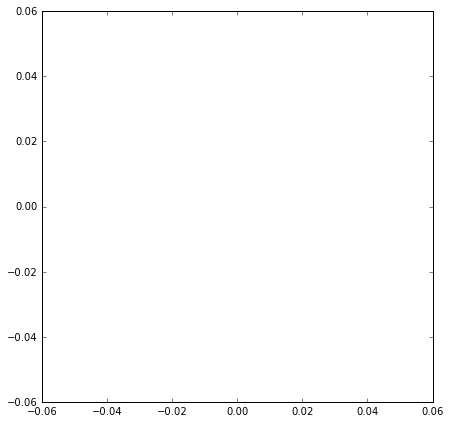

In [519]:
plt.figure(figsize=(7,7))
plt.plot(train_loss, 'b')
plt.plot(test_loss, 'r')

plt.show()

In [292]:
with open('fastrcnn_weights.pkl', 'wb') as f:
    params = [p.get_value() for p in detector.params]
    pk.dump(params, f)

In [ ]:
para

In [93]:
def trans_regions(regions):
    regs = np.zeros((regions.__len__(), 4))
    for i in range(regions.__len__()):
        regs[i] = regions[i]['rect']
    return regs

In [90]:
def num2label(num):
    if num == 0:
        return 'car'
    if num == 1:
        return 'bicycle'
    if num == 2:
        return 'bike'
    if num == 3:
        return 'person'
    else:
        return 'nothing'

In [92]:
im = imread(train_annotations[232]['image'])

In [94]:
regions = selective_search(im, scale=500, sigma=0.9, min_size=400)

In [95]:
regions = trans_regions(regions[1])
print regions.shape

(284, 4)


In [96]:
class_score, coord = detector.detect(im, proposals=regions[:50], thresh=.8)
print coord.shape
preds = np.concatenate((coord, np.max(class_score, axis=1, keepdims=True), \
                        np.argmax(class_score, axis=1).reshape((-1,1))), axis=1)

(1, 4)


In [97]:
print coord

[[ 0.01584642  0.44002295  0.04142132  1.17777312]]


In [98]:
reload(utils)

<module 'bnr_ml.objectdetect.utils' from '/usr/local/python/bnr_ml/objectdetect/utils.pyc'>

In [99]:
im_draw = utils.draw_coord(im, preds[:], label_map=num2label)

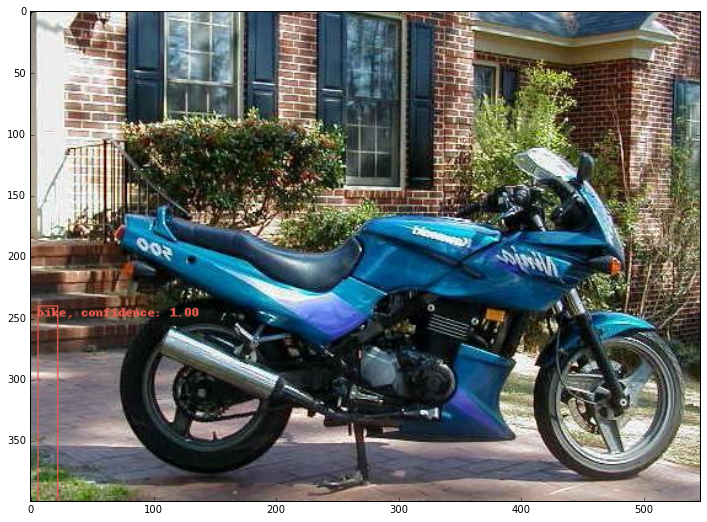

In [108]:
plt.figure(figsize=(12,12))
plt.imshow(im_draw)

In [285]:
target = T.matrix('target')

In [286]:
pred_fn = theano.function([detector.input], detector._detect_test)

In [287]:
acc = T.mean(T.eq(detector._detect_test.argmax(axis=1), target.argmax(axis=1)))
acc_fn = theano.function([detector.input, target], acc)

In [288]:
acc2_fn = theano.function([detector.input, target], T.eq(detector._detect_test.argmax(axis=1), target.argmax(axis=1)))

In [289]:
gen = fastrcnn.generate_rois(
    train_annotations[:200],
    input_shape,
    num_classes,
    lab2num,
    num_batch=2,
    N=25,
    neg=.5
)
# tdat = [g for g in gen]

In [138]:
X,y = tdat[1]

In [290]:
reload(fastrcnn)

<module 'bnr_ml.objectdetect.fastrcnn' from '/usr/local/python/bnr_ml/objectdetect/fastrcnn.pyc'>

In [291]:
accarr = []
# gen = fastrcnn.FastRCNNDetector.generate_data(test_annotations[:200], input_shape, num_classes, num_rios=1, per_batch=50)
for X,y in tqdm(gen):
    acc = acc_fn(X,y[:,-5:])
    print acc
    accarr.append(acc)
print np.mean(accarr)


0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]
1it [00:01,  1.48s/it]

  1%|          | 1/100 [00:01<02:26,  1.48s/it]

0.62



2it [00:02,  1.47s/it]

  2%|▏         | 2/100 [00:02<02:24,  1.47s/it]

0.52



3it [00:04,  1.46s/it]

  3%|▎         | 3/100 [00:04<02:22,  1.46s/it]

0.56



4it [00:05,  1.46s/it]

  4%|▍         | 4/100 [00:05<02:20,  1.46s/it]

0.58



5it [00:07,  1.46s/it]

  5%|▌         | 5/100 [00:07<02:18,  1.46s/it]

0.56



6it [00:08,  1.46s/it]

  6%|▌         | 6/100 [00:08<02:17,  1.46s/it]

0.56



7it [00:10,  1.47s/it]

  7%|▋         | 7/100 [00:10<02:16,  1.47s/it]

0.52



8it [00:11,  1.46s/it]

  8%|▊         | 8/100 [00:11<02:14,  1.46s/it]

0.56



9it [00:13,  1.47s/it]

  9%|▉         | 9/100 [00:13<02:13,  1.47s/it]

0.52



10it [00:14,  1.47s/it]

 10%|█         | 10/100 [00:14<02:12,  1.47s/it]

0.54



11it [00:16,  1.46s/it]

 11%|█         | 11/100 [00:16<02:10,  1.46s/it]

0.54



12it [00:17,  1.47s/it]

 12%|█▏        | 12/100 [00:17<02:09,  1.47s/it]

0.6



13it [00:19,  1.46s/it]

 13%|█▎        | 13/100 [00:19<02:07,  1.46s/it]

0.54



14it [00:20,  1.46s/it]

 14%|█▍        | 14/100 [00:20<02:05,  1.46s/it]

0.56



15it [00:21,  1.47s/it]

 15%|█▌        | 15/100 [00:21<02:04,  1.47s/it]

0.5



16it [00:23,  1.47s/it]

 16%|█▌        | 16/100 [00:23<02:03,  1.47s/it]

0.6



17it [00:24,  1.47s/it]

 17%|█▋        | 17/100 [00:24<02:01,  1.47s/it]

0.56



18it [00:26,  1.47s/it]

 18%|█▊        | 18/100 [00:26<02:00,  1.47s/it]

0.54



19it [00:27,  1.47s/it]

 19%|█▉        | 19/100 [00:27<01:59,  1.47s/it]

0.54



20it [00:29,  1.47s/it]

 20%|██        | 20/100 [00:29<01:57,  1.47s/it]

0.54



21it [00:30,  1.46s/it]

 21%|██        | 21/100 [00:30<01:55,  1.46s/it]

0.6



22it [00:32,  1.46s/it]

 22%|██▏       | 22/100 [00:32<01:54,  1.46s/it]

0.56



23it [00:33,  1.46s/it]

 23%|██▎       | 23/100 [00:33<01:52,  1.46s/it]

0.54



24it [00:35,  1.47s/it]

 24%|██▍       | 24/100 [00:35<01:51,  1.47s/it]

0.5



25it [00:36,  1.46s/it]

 25%|██▌       | 25/100 [00:36<01:49,  1.46s/it]

0.54



26it [00:38,  1.46s/it]

 26%|██▌       | 26/100 [00:38<01:47,  1.46s/it]

0.58


KeyboardInterrupt: 

In [115]:
swap = lambda im: im.swapaxes(0,1).swapaxes(1,2)

In [116]:
idx = np.arange(X.shape[0])[np.bitwise_not(acc2_fn(X,y[:,-5:]).astype(np.bool))]

In [175]:
N = int(X.shape[0] * np.random.rand())

In [176]:
im, lab, pred = swap(X[N]), num2label(y[N,-5:].argmax()), pred_fn(X[[N]])[0]

Prediction: nothing, Conf: 1.0, Ground Truth: nothing


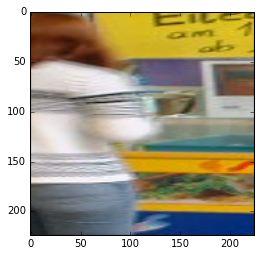

In [177]:
plt.imshow(im)
print('Prediction: %s, Conf: %s, Ground Truth: %s' % (num2label(pred.argmax()), pred.max(), lab))

In [ ]:
N